Code taken from: https://github.com/pytorch/examples/tree/master/vae

In [1]:
! pip install sklearn

In [2]:
! pip install Cython

In [3]:
! git clone https://github.com/franciscovillaescusa/Pylians

fatal: destination path 'Pylians' already exists and is not an empty directory.


In [4]:
! cd Pylians/library/ python setup.py build

In [5]:
# from Pylians.library import Pk_library
# import Pylians as PKL
# from Pylians.library import Pk

In [6]:
%load_ext Cython

In [7]:
%load_ext cythonmagic

/beegfs/sb3923-share/pytorch-cpu/py3.6.3/lib/python3.6/site-packages/IPython/extensions/cythonmagic.py:21: UserWarning: The Cython magic has been moved to the Cython package
  warnings.warn("""The Cython magic has been moved to the Cython package""")


In [8]:
%% cython
import cython
from cython cimport floating

UsageError: Cell magic `%%` not found.


### Pk Library Functions

In [9]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [10]:
## model imports
from __future__ import print_function
import argparse
import numpy as np
import os
import h5py
import pickle as pkl
import random
# from mpi4py import MPI
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## normal noise input
from torch.distributions import normal

## plot imports
import itertools
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import h5py
import matplotlib as mpl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
## sampling from normal
m = normal.Normal(0.2,0.3)
m.sample()

tensor(0.2470)

### Section 0: Plotting

#### Cube Visualization - 3D

In [12]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Function for dividing/truncating cmaps"""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def visualize_cube(cube=None,      ## array name
             edge_dim=None,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=None,
             norm_multiply=600,
             color_map="Blues",
             lognormal=False):
    
    """Takes as input;
    - cube: A 3d numpy array to visualize,
    - edge_dim: edge length,
    - fig_size: Figure size for the plot,
    - norm_multiply: Multiplication factor to enable matplotlib to 'see' the particles,
    - color_map: A maplotlib colormap of your choice,
    - lognormal: Whether to apply lognormal transformation or not. False by default.
    
    Returns: 
    - The cube visualization"""
    
    ## plot all the cubes in the batch
    
    # pdf's - original and regenerated
    
    # cube visuals
    
    # power spectrum
    
    
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    
#     initial_mean = np.mean(data_1dim) - stdev_to_white*np.std(data_1dim)
#     mask = data_1dim > initial_mean
#     mask = mask.astype(np.int)
    
#     data_1dim = np.multiply(mask,data_1dim)
    ## mask X,Y,Z to match the dimensions of the data
    X, Y, Z, data_1dim = [axis[np.where(data_1dim>0)] for axis in [X,Y,Z,data_1dim]]

    if lognormal == False:
        s = norm_multiply*data_1dim/np.linalg.norm(data_1dim)
    else:
        s = np.log(norm_multiply*data_1dim/np.linalg.norm(data_1dim))
    
    cmap=plt.get_cmap(color_map)
    new_cmap = truncate_colormap(cmap, 0.99, 1,n=10)
    
    ## IGNORE BELOW 3D PLOT FORMATTING 
    
    ## plot cube
    
    cube_definition = [(start_cube_index_x, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x+edge_dim, start_cube_index_x),
                      (start_cube_index_x+edge_dim, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x, start_cube_index_x+edge_dim)]
    
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]
    
    
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    
    
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    
#     ax.fig.add_subplot(111, projection='3d')
    
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k',)
    faces.set_facecolor((0,0,1,0)) ## set transparent facecolor to the cube
    
    ax.add_collection3d(faces)
    
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    ax.set_aspect('equal')
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    ax.xaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.yaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.zaxis.set_major_locator(MultipleLocator(edge_dim))
    
    ax.grid(False)
    
    ax.set_xlim3d(0,edge_dim)
    ax.set_ylim3d(0,edge_dim)
    ax.set_zlim3d(0,edge_dim)
#     ax.get_frame_on()
    
    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0
    
    ax.scatter(X, Y, Z,       ## axis vals
               c=data_1dim,   ## data, mapped to 1-dim
               cmap=new_cmap,
               s=s,           ## sizes - dims multiplied by each data point's magnitude
               alpha=0.7,
               edgecolors="face")
    
    
    
    plt.show()

#### Mass Histogram Function

In [13]:
datapath=''
redshift = '0.0'
f = h5py.File("minmax_scale_01_redshift1.h5", 'r')
f=f['delta_HI']

def cube_mass_histogram(cube=None,      ## array name
             edge_dim=128,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=(20,10),
             stdev_to_white=1,
             norm_multiply=1,
             color_map="Blues",
             lognormal=False,
             hist_color="b",
                       hist_bins=300,
                       xlim=None):
    
    ## adjust cube and get 1d array of in-cube masses
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    ## start plotting
    plt.figure(figsize=fig_size)
    plt.hist(data_1dim,bins=hist_bins,
            alpha=0.4)
    
    if xlim != None:
        plt.xlim(xlim[0],xlim[1])
    else:
        plt.xlim(None)
        
    plt.xlabel("Masses")
    plt.ylabel("Number of Samples That Correspond to the Mass")
    plt.title("Output Mass Histogram")
    plt.show()

### Arguments

In [14]:
# modify to accept hard coded arguments
# batch_size = 8
batch_size = 16
# batch_size = 32
epochs = 100
no_cuda = False
log_interval = 1

cuda = not no_cuda and torch.cuda.is_available()
# cuda = True

seed = 1
torch.manual_seed(seed)


# device = torch.device("cuda" if args.cuda else "cpu")
device = torch.device("cuda" if cuda else "cpu")

# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

### Section 1: Sampling & Preprocessing

In [15]:
scaler = StandardScaler()

#### Functions

In [16]:
def define_test(s_test, s_train):
    #2048/16=128
    m=8
    x=random.randint(0,m)*s_train
    y=random.randint(0,m)*s_train
    z=random.randint(0,m)*s_train
    #print(x,y,z)
    return {'x':[x,x+s_test], 'y':[y,y+s_test], 'z':[z,z+s_test]}

def check_coords(test_coords, train_coords):
    valid=True
    for i in ['x','y','z']:
        r=(max(test_coords[i][0], 
               train_coords[i][0]), 
           min(test_coords[i][1],
               train_coords[i][1]))
        if r[0]<=r[1]:
            valid=False
    return valid

# def get_samples(datapath, s_sample, nsamples, redshift, test_coords):
#     #n is size of minibatch, get valid samples (not intersecting with test_coords)
#     sample_list=[]
#     m=2048-128
#     for n in range(nsamples):
#         #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
#         sample_valid=False
#         while sample_valid==False:
#             x = random.randint(0,m)
#             y = random.randint(0,m)
#             z = random.randint(0,m)
#             sample_coords = {'x':[x,x+s_sample], 
#                              'y':[y,y+s_sample], 
#                              'z':[z,z+s_sample]}
            
#             sample_valid = check_coords(test_coords, sample_coords)
        
#         sample_list.append(sample_coords)
    
#     #print("Sampling finished.")
        
#     #Load cube and get samples and convert them to np.arrays
#     sample_array=[]
#     #datapath='../../../../../'
#     #f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
#     #f=f['delta_HI']
    
#     counter = 0
#     for c in sample_list:
#         #if counter%100==0:
#         #    print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
#         a = f[c['x'][0]:c['x'][1],
#               c['y'][0]:c['y'][1],
#               c['z'][0]:c['z'][1]]
        
#         #a = np.array(a)
#         a = np.array(a)
#         sample_array.append(a)
    
#         counter = counter + 1
        
    
#     return sample_array



## OLD
def get_samples(filepath, s_sample, nsamples, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-128
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, 
                                        sample_coords)
        
        sample_list.append(sample_coords)
    
    print("Sampling finished.")
        
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    datapath=''
    f = h5py.File(filepath, 'r')
#     f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
#     f = scaler.fit_transform(np.array(f))
    
    # getting the max of the whole cube
    #print(f.shape)
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
    #f.close()
    
    print("Getting max value finished.")
    
    counter = 0
    for c in sample_list:
        print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        # a = np.array(a)
        ### datayi -1 1 arasina almayi dene
        
#         a = np.array(a) / max_cube
#         a = np.array([scaler.fit_transform(np.array(x)) for x in a])
#         a = (a - np.mean(a)*np.ones(a.shape))/np.std(a)
#         a = 
        a = np.array(a)/max_cube
        a = a + 1
        a = np.log(a)

        sample_array.append(a)

        counter = counter + 1
        
    f=0
    sample_array = np.array(sample_array)
    return sample_array

In [17]:
# class HydrogenDataset(Dataset):
#     """Hydrogen Dataset"""

#     def __init__(self, root_dir, s_test, s_sample, nsamples, redshift, transform):
#         """
#         Args:
#             h5_file (string): name of the h5 file with 32 sampled cubes.
#             root_dir (string): Directory with the .h5 file.
#         """
#         #file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
#         #print("The whole file size is " + str(int(file_size)) + " MBs")
        
#         # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
#         self.root_dir = root_dir
#         self.s_test = s_test
#         self.s_sample = s_sample
#         self.t_coords = define_test(self.s_test,self.s_sample)
#         self.nsamples = nsamples
#         self.redshift = redshift
#         self.transform = transform
#         self.filepath = filepath
#         if self.transform == 'max':
#             self.max_cube=get_max_cube(self.root_dir, self.redshift)
#        # if self.transform=='normalize':
#         #    self.mean=
#          #   self.std=

#     def __len__(self):
#         # Function called when len(self) is executed
#         return self.nsamples

#     def __getitem__(self, idx):
#         """
#         This can be implemented in such a way that the whole h5 file read 
#         using h5py.File() and get_sample() function is called to return
#         a random subcube. This won't increase memory usage because the
#         subcubes will be read in the same way and only the batch will
#         be read into memory.
        
#         Here we have implemented it so that it can be used with data
#         generated by get_sample() function.
        
#         The output of this function is one subcube with the dimensions
#         specified by get_sample() implementation.
#         """
        
#         sample = get_samples(filepath=self.filepath,
#                             s_sample = self.s_sample,
#                              nsamples = 1,
#                              test_coords = self.t_coords)
        
#         if self.transform=='max':
#             sample = sample / np.array(self).max_cube
#         if self.transform=='normalize':
#             sample = (np.array(sample)-np.array(self).mean)/np.array(self).std
    
#         sample=np.array(sample).reshape((1,self.s_sample,self.s_sample,self.s_sample))

#         return sample

In [18]:
def get_statistics(datapath, redshift):
    f_ = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f_['delta_HI']
    
    max_list, min_list, mean_list, variance_list= [], [], [], []
   
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
        min_list.append(np.min(f[i:i+1,:,:]))
        mean_list.append(np.mean(f[i:i+1,:,:]))
        #variance_list.append(np.mean(np.square(f[i:i+1,:,:] - mean_cube)))
    #mean_cube = np.mean(mean_list)
    #for i in range(f.shape[0]):
    
    f.close()
    
    max_cube = max(max_list)
    min_cube = min(min_list)
    mean_cube = np.mean(mean_list)
    #stddev_cube = np.sqrt(np.mean(variance_list))
    return max_cube, min_cube, mean_cube
    

def get_max_cube(datapath, redshift):
    f= h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
   
    return max_cube

def get_min_cube(datapath, redshift):
    min_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        min_list.append(np.min(f[i:i+1,:,:]))
    min_cube = min(min_list)
    return min_cube

def get_mean_cube(datapath, redshift):
    mean_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        mean_list.append(np.mean(f[i:i+1,:,:]))
    mean_cube = np.mean(mean_list)
    return mean_cube

def get_stddev_cube(datapath, redshift, mean_cube):
    variance_list = []
    for i in range(f.shape[0]):
        variance_list.append(np.mean(np.square(f[i:i+1,:,:] - mean_cube)))
    stddev_cube = np.sqrt(np.mean(variance_list))
    return stddev_cube

In [19]:
t_coords=define_test(1024,128)

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
class HydrogenDataset2(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, filepath,h5_file, root_dir, s_test, s_train,
                 s_sample, nsamples, redshift):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        print("The whole file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.subcubes = h5py.File(root_dir + h5_file, 'r')["delta_HI"]
        self.h5_file = h5_file
        self.root_dir = root_dir
        self.s_test = s_test
        self.s_train = s_train
        self.t_coords = define_test(self.s_test,
                                    self.s_train)
        self.s_sample = s_sample
        self.nsamples = nsamples
        self.redshift = redshift, 
        self.filepath = filepath
        
        self.samples = get_samples(filepath = self.filepath, s_sample =self.s_sample,
                             nsamples = self.nsamples,
                             test_coords = self.t_coords)

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
#         return len(self.nsamples)
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
#         sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
#         sample = self.subcubes[idx].reshape((1,128,128,128))

        # On prince using get_samples()
#         print("nsamples = " + str(self.nsamples))
#         sample = get_samples(s_sample = self.s_sample,
#                              nsamples = self.nsamples,
#                              redshift = self.redshift,
#                              test_coords = self.t_coords)
    
        sample = torch.FloatTensor(self.samples[idx].reshape((1,128,128,128)))
        
        # added division by 1e6 for exploding variance
        # and resulting in inf during reparametrization trick part
#         sample = sample/1e6
        
        ##3 normalize here 
        
#         sample = sample/1e6

        return sample

#### Transform: Min-Max 0-1

In [22]:
sampled_subcubes = HydrogenDataset2(h5_file="minmax_scale_01_redshift1.h5", #"fields_z=1.0.hdf5",
                                    root_dir = "",
                                    s_test = 1024, 
                                    s_train = 128,
                                    s_sample = 128, 
                                    nsamples = 256, 
                                    redshift = "1.0",
                                    filepath="minmax_scale_01_redshift1.h5")

The whole file size is 68719 MBs
Sampling finished.
Getting max value finished.
Counter = 1 / 256
Counter = 2 / 256
Counter = 3 / 256
Counter = 4 / 256
Counter = 5 / 256
Counter = 6 / 256
Counter = 7 / 256
Counter = 8 / 256
Counter = 9 / 256
Counter = 10 / 256
Counter = 11 / 256
Counter = 12 / 256
Counter = 13 / 256
Counter = 14 / 256
Counter = 15 / 256
Counter = 16 / 256
Counter = 17 / 256
Counter = 18 / 256
Counter = 19 / 256
Counter = 20 / 256
Counter = 21 / 256
Counter = 22 / 256
Counter = 23 / 256
Counter = 24 / 256
Counter = 25 / 256
Counter = 26 / 256
Counter = 27 / 256
Counter = 28 / 256
Counter = 29 / 256
Counter = 30 / 256
Counter = 31 / 256
Counter = 32 / 256
Counter = 33 / 256
Counter = 34 / 256
Counter = 35 / 256
Counter = 36 / 256
Counter = 37 / 256
Counter = 38 / 256
Counter = 39 / 256
Counter = 40 / 256
Counter = 41 / 256
Counter = 42 / 256
Counter = 43 / 256
Counter = 44 / 256
Counter = 45 / 256
Counter = 46 / 256
Counter = 47 / 256
Counter = 48 / 256
Counter = 49 / 25

In [23]:
type(sampled_subcubes)

__main__.HydrogenDataset2

In [24]:
# [*sampled_subcubes][0][:5,:5,:5]

In [25]:
np.mean(np.array(sampled_subcubes[1]))

2.2247232e-06

In [26]:
np.std(np.array(sampled_subcubes[1]))

0.00035880628

In [27]:
np.min(np.array(sampled_subcubes[1]))

0.0

In [28]:
np.max(np.array(sampled_subcubes[1]))

0.18436322

In [29]:
# np.save("my_HI_field.npy",sampled_subcubes[1])

In [30]:
# ! ls Pylians/library/Pk_library/

In [31]:
# import Pylians as PKL
# from Pylians.PKL import Pk

# ## example Pylians

# delta = np.load("my_HI_field.npy")
# delta /= np.mean(delta, dtype=np.float64)  
# delta -= 1.0
# delta = delta.astype(np.float32)

# BoxSize = 75.0/2048*128
# axis=0
# MAS="CIC"
# threads=1

# Pk = PKL.Pk(delta, BoxSize, axis, MAS, threads)

# np.savetxt("my_Pk.txt", np.transpose([Pk.k3D, Pk.Pk[:,0]]))

### Section 2: Model and Data Loaders

In [32]:
# Data Loaders
train_loader = DataLoader(
        dataset=sampled_subcubes,
        #batch_size=args.batch_size, 
        batch_size=batch_size,
        shuffle=True, 
        **kwargs)

test_loader = DataLoader(
        dataset=sampled_subcubes,
        #batch_size=args.batch_size, 
        batch_size=batch_size,
        shuffle=True, 
        **kwargs)

#### Model

New

In [33]:
torch.FloatTensor([2,3,4]).data.shape

torch.Size([3])

In [34]:
torch.div(torch.FloatTensor([2,3,4]),2)

tensor([1.0000, 1.5000, 2.0000])

In [35]:
# A = [*train_loader][0]

In [36]:
# torch.div(A,1e6)

In [80]:
# Skeleton code taken from: https://chrisorm.github.io/AVB-pyt.html
# Thanks to Rob Fergus: https://cs.nyu.edu/~fergus/teaching/vision/10_unsupervised.pdf

class VAE(nn.Module):
    def __init__(self, mode="training"):
        super(VAE, self).__init__()
        
        """Takes as input;
        - mode: 'training' or 'inference'. 
        If mode == 'training' reparametrizes encoder output and 
        reconstructs the given input, 
        Elif mode == 'inference', a sample (batch_size x hidden_size)
        drawn from a zero-mean, univariance Gaussian is passed to the 
        decoder."""
        
        # pass train or test mode to adjust decoder input
        # as reconstruction or noise
        self.mode = mode
        
        ########################
        #### ENCODER LAYERS ####
        ########################
        
        # Convolutional Layer 1
        self.encode_conv1 = nn.Conv3d(in_channels=1, 
                                      out_channels=8, 
                                      kernel_size=(4,4,4), # == 4
                                      stride = (2,2,2), # == 2
                                      padding=(1,1,1)) # == 1
        nn.init.xavier_uniform_(self.encode_conv1.weight) #Xaviers Initialization
        
        self.encode_relu1 = nn.ReLU()
        
        self.encode_maxpool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2),
                                            return_indices = True)
        
        # Convolutional Layer 2
        self.encode_conv2 = nn.Conv3d(in_channels=8, 
                                      out_channels=16, 
                                      kernel_size=(4,4,4), # == 4 
                                      stride = (2,2,2),
                                      padding=(1,1,1))
        nn.init.xavier_uniform_(self.encode_conv2.weight) #Xaviers Initialization
        
        self.encode_relu2 = nn.ReLU()
        self.encode_maxpool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
                                             stride=(2, 2, 2),
                                            return_indices = True)
        
        # Convolutional Layer 3
        self.encode_conv3 = nn.Conv3d(in_channels=16, 
                                      out_channels=32, 
                                      kernel_size=(4,4,4), # == 4 
                                      stride = (2,2,2),
                                      padding=(1,1,1))
        self.encode_relu3 = nn.ReLU()
        nn.init.xavier_uniform_(self.encode_conv3.weight) #Xaviers Initialization
        
        
        """
        Fully Connected Layers after 3D Convolutional Layers
        First FC layer's input should be equal to 
        last convolutional layer's output
        8192 = 8^3 * 16 
            8^3 = (output of 2nd convolutional layer)
            16 = number of out_channels
        """
        
        # First Fully Connected Layer
        self.encode_fc1_linear = nn.Linear(in_features=2048, ## 2048
                                           out_features=128)
        
        self.encode_fc1_relu = nn.ReLU()
        self.encode_fc1_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc1_linear.weight) #Xaviers Initialization
        
        # Second Fully Connected Layer
        self.encode_fc2_linear = nn.Linear(in_features=128, 
                                           out_features=128)
    

        self.encode_fc2_relu = nn.ReLU()
    
        self.encode_fc2_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc2_linear.weight) #Xaviers Initialization
        
        """
        The last fully connected layer's output is the dimensions
        of the embeddings?
        
        PyTorch VAE example uses output of 20 dimensions for mu &
        logvariance
        """
        
        # Last Fully Connected Layer
        self.encode_fc31_linear = nn.Linear(in_features=128,
                                            out_features=16) 
        
        self.encode_fc31_relu = nn.ReLU()
        
        self.encode_fc31_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc31_linear.weight) #Xaviers Initialization

        self.encode_fc32_linear = nn.Linear(in_features=128, 
                                           out_features=16)
        
        self.encode_fc32_relu = nn.ReLU()
    
        self.encode_fc32_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc32_linear.weight) #Xaviers Initialization
        
        ########################
        #### DECODER LAYERS ####
        ########################
        
        # First Fully Connected Layer
        self.decode_fc1 = nn.Sequential(
            nn.Linear(in_features=16,
                      out_features=128))
        
        # Second Fully Connected Layer
        self.decode_fc2 = nn.Sequential(
            nn.Linear(in_features=128, 
                      out_features=128), 
            nn.ReLU(),
            nn.Dropout(0.5))
        
        # Third Fully Connected Layer
        self.decode_fc3 = nn.Sequential(
            nn.Linear(in_features = 128,
                      out_features = 2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        
        # Convolutional Layer 1
        self.decode_conv1 = nn.ConvTranspose3d(in_channels=32, 
                                              out_channels=16, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu1 = nn.ReLU()
        self.decode_maxunpool1 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        # Convolutional Layer 2
        self.decode_conv2 = nn.ConvTranspose3d(in_channels=16, 
                                              out_channels=8, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu2 = nn.ReLU()
        self.decode_maxunpool2 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        # Convolutional Layer 3
        self.decode_conv3 = nn.ConvTranspose3d(in_channels=8, 
                                              out_channels=1, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu3 = nn.ReLU()
        self.decode_maxunpool3 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        ## initialize out lists 
        self.first_decode_out_sum = []
        self.conv_1_out_sum = []
        self.relu_1_out_sum = []
        self.max_unpool_1_out_sum = []
        self.conv_2_out_sum = []
        self.relu_2_out_sum = []
        self.max_unpool_2_out_sum = []
        self.conv_3_out_sum = []
        self.relu_3_out_sum = []
        
        
        # Encoding part of VAE
    def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

        print("Starting Encoding")
#         print("----------------------------")
        
        out = self.encode_conv1(x)
#         print("First Conv output shape = " + str(out.shape))
        #print(out.shape)
        out = self.encode_relu1(out)
#         print("First ReLU Layer output shape = " + str(out.shape))
        size1 = out.size()
        out, ind1 = self.encode_maxpool1(out)
#         print("First MaxPooling output shape = " + str(out.shape))
#         print("Ind1 shape = " + str(ind1.shape))
#         #print("Size1 = " + str(size1))
#         print("----------------------------")
        
        out = self.encode_conv2(out)
#         print("Second Conv output shape = " + str(out.shape))
        out = self.encode_relu2(out)
#         print("Second ReLU Layer output shape = " + str(out.shape))
        size2 = out.size()
        out, ind2 = self.encode_maxpool2(out)
#         print("Second MaxPooling output shape = " + str(out.shape))
#         print("Ind2 shape = " + str(ind2.shape))
        #print("Size2 = " + str(size2))
#          print("----------------------------")
        
        out = self.encode_conv3(out)
#         print("Last Conv output shape = " + str(out.shape))
        out = self.encode_relu3(out)
#         print("Last ReLU output shape = " + str(out.shape))
        size3 = out.size()
#         out, ind3 = self.encode_maxpool3(out)
#         print("Last Conv Layer output shape = " + str(out.shape))
#         print("Ind3 shape = " + str(ind3.shape))
#         print("Size3 = " + str(size3))
#         print("----------------------------")

        """
        From here on, the convolutional layers' output is flattened
        into a rank 1 tensor of size x & put into a fully connected 
        network to output ??????
        
        https://github.com/pytorch/examples/blob/master/vae/main.py
        PyTorch's own example uses just 2 fully-connected layers
        to output mu and logvar predictions, below we use 3.
        """
        #out = out.view(out.size(0), -1)
        
        
        # batch_size = 1 - WORKS
#         out = out.view(1, -1)
        # batch_size != 1
        out = out.view(batch_size, -1)
#         print(out.shape)
        
#         print("Last Conv Layer output shape after reshaping \n \
#                 (Input to first FC layer) = " + str(out.shape))
        
#         out = self.encode_fc1(out)
    
        out = self.encode_fc1_linear(out)
        
        ## RELU TO LEAKY RELU
        out = self.encode_fc1_relu(out)
#         out = self.encode_LeakyReLU_1(out)
        
        out = self.encode_fc1_dropout(out)
#         out = self.encode_fc2(out)

        out = self.encode_fc2_linear(out)
    
        ## RELU TO LEAKY RELU
        out = self.encode_fc2_relu(out)
#         out = self.encode_LeakyReLU_2(out)
        out = self.encode_fc2_dropout(out)
        
        
#         out_mu = self.encode_fc31(out)
        
        out_mu = self.encode_fc31_linear(out)
        
        ## RELU TO LEAKY RELU
        out_mu = self.encode_fc31_relu(out_mu)
        out_mu = self.encode_fc31_dropout(out_mu)
        
#         out_logvar = self.encode_fc32(out)

        out_logvar = self.encode_fc32_linear(out)
    
        ## RELU TO LEAKY RELU
        out_logvar = self.encode_fc32_relu(out_logvar)
#         out_logvar = self.encode_LeakyReLU_32(out_logvar)
        
        out_logvar = self.encode_fc32_dropout(out_logvar)
        
        print("Encode - Forward Pass Finished")
#         print(out_mu.shape)
#         print(out_logvar.shape)
#         print("----------------------------")

        return out_mu, out_logvar, [ind1,ind2], [size1,size2]
    
        
#     Reparametrization Trick in training mode,
#     N(0,1) Gaussian sample for inference mode.
    def reparameterize(self, mu, logvar):
        """
        torch.exp = returns a new tensor with the exponential of 
                    the elements of input
        rand_like = returns a tensor with the same size as input
                    that is filled with random numbers from a normal
                    distribution with mean 0 and variance 1
        
        """
        assert self.mode in ["training","inference"], "Mode should be either 'training' or 'inference'."
        
        if self.mode == "training":
            mu = mu
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            z = eps.mul(std).add_(mu)
        
        elif self.mode == "inference":
            # input values from 0-mean univariance 
            # Gaussian distribution
            
            # sample from Gaussian
            ## sampling from normal
            
            m = normal.Normal(0,1)
            noise = m.sample(mu.data.shape) # returns torch.Size([x,y,z])
            z = noise
        
        return z
        
        
    def decode(self, z, indices_list, size_list):
        
        print("Starting Decoding")
#         print("z shape = " + str(z.shape))
        
        ### buradaki butun outlarin sumlarina bak 
        out = self.decode_fc1(z)
#         print("1st FC output shape = " + str(out.shape))
        out = self.decode_fc2(out)
#         print("2nd FC output shape = " + str(out.shape))
        out = self.decode_fc3(out)
#         print("Last FC output shape = " + str(out.shape))
        
        # batch_size = 1 - WORKS
#         out = out.view(1, 32, 4, 4, 4)
        # batch_size != 1 
        out = out.view(batch_size, 32, 4, 4, 4)
#         out = out.view(batch_size, 32, )
        self.first_decode_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("FIRST DECODE OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
#         print("First Deconv input shape = " + str(out.shape))
#         print("After last convolution (encoding stage) output shape = " +\
#                   str(indices_list[1].shape))
        out = self.decode_conv1(out)
        self.conv_1_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("First Deconv output shape = " + str(out.shape))
        
        ## RELU TO LEAKY RELU
        out = self.decode_relu1(out)
        self.relu_1_out_sum.append(np.sum(out.cpu().detach().numpy()))

        print ("RELU 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("First ReLU output shape = " + str(out.shape))
        # maxunpooling needs indices

#         out = self.decode_maxunpool1(out,
#                              indices = indices_list[1])
        out = self.decode_maxunpool1(out,
                                     indices = indices_list[1],
                                     output_size = size_list[1])
    
        self.max_unpool_1_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("MAX UNPOOL 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd MaxUnpool ouput shape = " + str(out.shape))
        
        out = self.decode_conv2(out)
        self.conv_2_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd Deconv output shape = " + str(out.shape))

        ## RELU TO LEAKY RELU
        out = self.decode_relu2(out)
        self.relu_2_out_sum.append(np.sum(out.cpu().detach().numpy()))

        print ("RELU 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd ReLU output shape = " + str(out.shape))
        out = self.decode_maxunpool2(out,
                     indices = indices_list[0])
        self.max_unpool_2_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("MAX UNPOOL 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         out = self.decode_maxunpool2(out,
#                                      indices= indices_list[1],
#                                      output_size = size_list[1])
        
        out = self.decode_conv3(out)
        self.conv_3_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 3 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
        ## RELU TO LEAKY RELU
        out = self.decode_relu3(out)
        print ("decoder out size = "+str(out.size()))
        self.relu_3_out_sum.append(np.sum(out.cpu().detach().numpy()))

        print ("RELU 3 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
        return out, self.first_decode_out_sum, self.conv_1_out_sum, self.relu_1_out_sum, \
                    self.max_unpool_1_out_sum,\
                    self.conv_2_out_sum, self.relu_2_out_sum, self.max_unpool_2_out_sum, \
                    self.conv_3_out_sum, \
                    self.relu_3_out_sum
    
    # Forward Pass
    def forward(self, x):
        
        if self.mode == "inference":
            # will use these for size consistency only,
            # we are not inputting any encoding in inference mode
            # besides N(0,1) - 0-mean, univariance Gaussian noise
            mu, logvar, indices_list, size_list = self.encode(x)
            # input noise in the decoder instead of reparametrized input
            # please check the reparametrize function for further clarification
            z = self.reparameterize(mu, logvar)
            # return noise-input reconstruction (reconstructed_x)
            # returning all these output sums to check if the decoder
            # works correctly
            output_cube,\
            first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
            conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
            relu_3_out_sum = self.decode(z, indices_list, size_list)
            
        elif self.mode == "training":
            # if the VAE network is in training mode,
            # we reparametrize the encoder output, then pass the
            # reparametrized representation into the decoder for 
            # reconstructuion. Here we are only reconstructing whatever 
            # "cube" sample of the space was passed into the encoder.
            mu, logvar, indices_list, size_list = self.encode(x)
            z = self.reparameterize(mu, logvar)
            
            output_cube,\
            first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
            conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum,\
            relu_3_out_sum = self.decode(z, indices_list, size_list)
        
        # changed the output name to output_cube (from reconstructed_x) because it 
        # was confusing when we are running in inference mode. Since, in 
        # the inference/noise input case it's just a cube generation using the
        # trained network rather than "reconstructing" an input.
        return output_cube,\
               first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
               conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum,\
               relu_3_out_sum , mu, logvar

In [81]:
torch.zeros((3,3))

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [82]:
int(torch.std(torch.FloatTensor([2,3,4,60])))

28

In [83]:
## sampling from normal
m = normal.Normal(0.2,0.3)
m.sample(torch.Size([3,3]))

tensor([[ 0.4566,  0.3154, -0.2100],
        [ 0.2036,  0.2381,  0.3013],
        [ 0.6383,  0.1275,  0.2529]])

In [84]:
model = VAE().to(device)

In [85]:
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001,
                      weight_decay=0.000001,
                      eps=1e-7) ## change learning rate

#### Loss Function

In [86]:
# # Reconstruction + KL divergence losses summed over all elements and batch
# def loss_function(recon_x, x, mu, logvar):

#     """
#     https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776
#     This article is about reconstructing MNIST dataset (2D images with 1 channels)
#     And it uses squared difference for the reconstruction loss, thus
#     it is safe to say that for 3D reconstruction we might use the same thing too.
    
#     But the MSE loss seems to be around 1e20 magnitude, thus suggesting some
#     bug might exist in it.
#     The multplication by 1e12 is because of the 1e6 division when loading
#     the dataset
#     """
#     MSE = F.mse_loss(recon_x, 
#                      x.view(-1, 1, 128, 128, 128), 
#                      reduction='sum')
    
#     print("MSE Loss = " + str(MSE))

#     """
#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
#     # https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/
#     # normalises the KLD loss by batch_size
#     """

#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     KLD = KLD / float(batch_size)
#     print("KLD Loss = " + str(KLD))

#     return MSE + KLD
# #     return KLD

In [87]:
2*torch.FloatTensor([2,3,4])

tensor([4., 6., 8.])

In [88]:
def ELBO(recon_x, x, mu, logvar):
    """
    Computes ELBO =  Log Likelihood - KL Divergence 
    
    We want to maximize ELBO, so ELBO function returns 
    -1*ELBO, to pass it to the optimizer more conveniently. 
    
    """
    
    # LOG LIKELIHOOD (-CROSS ENTROPY), THE FIRST TERM OF ELBO
    
    print("--------------------------------------")
    print("Calculating Loss...")
    print("recon_x shape = " + str(recon_x.shape))
    
    BCE = F.binary_cross_entropy(recon_x, 
                                 x.view(-1, 1, 128, 128, 128), 
                                 reduction='sum')
    print("BCE Loss = " + str(BCE))
    
    LogLikelihood = (-1)*BCE

        
    # NLL_Loss(input, target)
#     x = torch.LongTensor(x)
#     recon_x = torch.LongTensor(recon_x)

#     ## UNDERSTAND NLL LOSS DIMENSIONS, LONGTENSOR ETC
#     recon_nll = recon_x.view(batch_size,-1,1)
#     recon_logits = torch.max(F.softmax(recon_nll),1)[0].squeeze().view(-1,1)
#     print ("recon_nll_size = "+ str(recon_nll.size()))
# #     print ("recon_logits_size = "+ str(len(recon_logits)))
#     print ("recon logits = "+str(recon_logits))
#     x_nll = x.view(batch_size,-1,1)
#     x_logits = torch.max(F.softmax(x_nll),1)[0].squeeze().view(-1,1).type(torch.LongTensor)
#     print ("x_nll_size = "+ str(x_nll.size()))
# #     print ("x_logits_size = "+str(len(x_logits)))
#     print ("x_logits = "+str(x_logits))
#     NLL = NLL_loss(recon_logits, 
#                    x_logits)
# #     for i in range(batch_size):
# #         NLL = NLL_loss(recon_x[i], 
# #                    x[i][0])
#     LogLikelihood = -1*NLL

    # KL DIVERGENCE - THE SECOND TERM OF ELBO
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print ("KLD =" +str(KLD))
    ELBO = (LogLikelihood - KLD)/float(batch_size)
    print ("ELBO = "+str(ELBO))
    
    return (-1)*ELBO


#### Train and Test Epochs

In [89]:
decoder_sum_lists = {}

for out_plot in ["first_decode_out_sum", "conv_1_out_sum", "relu_1_out_sum", "max_unpool_1_out_sum",
            "conv_2_out_sum", "relu_2_out_sum", "max_unpool_2_out_sum", "conv_3_out_sum", \
            "relu_3_out_sum"]:

    decoder_sum_lists[out_plot] = []

def train(epoch):
    model.train()
    train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
    for batch_idx, data in enumerate(train_loader):
#         print(batch_idx)
#         print(data)
        
        #print("Batch size = " + str(data.shape))
        
        data = data.to(device)
        print("Data transfer to device completed.")
        
        optimizer.zero_grad()
        
        recon_batch, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
                    conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
                    relu_3_out_sum , mu, logvar = model(data)
            
        # Plotting Input Cube
        print("data shape = " + str(data.view(-1,128,128,128).shape))
        print("data shape = " + str(data[0].cpu().view(128,128,128).numpy().shape))
        
#         if epoch % (epochs / 20) == 0 and batch_idx == 1:
            
            ## plot first_decoder out


        if epoch > 1 and epoch % (epochs / 50) == 0 and batch_idx == 0:
            print ("Plotting the first decoder output sum")
#         print ("first decoder out sum = "+str(first_decode_out_sum))
            plt.figure(figsize=(20,10))
            plt.plot(first_decode_out_sum, linewidth=3.5, alpha=0.6, 
                     color="b")
            plt.rcParams["font.size"] = 16
            plt.xlabel("Batch Iterations")
            plt.title("First Decoder Output Sum")
    #             plt.xticks = range(epochs)
    #             plt.grid()
            plt.show()

            ## plot first convolution out
            print ("Plotting the first convolution output sum")
            plt.figure(figsize=(20,10))
            plt.plot(conv_1_out_sum, linewidth=3.5, alpha=0.6, 
                     color="r")
            plt.rcParams["font.size"] = 16
            plt.xlabel("Batch Iterations")
            plt.title("First Convolution Output Sum")
    #             plt.xticks = range(epochs)
    #             plt.grid()
            plt.show()

            ## plot first relu out
            print ("Plotting the first relu output sum")
            plt.figure(figsize=(20,10))
            plt.plot(relu_1_out_sum, linewidth=3.5, alpha=0.6, 
                     color="m")
            plt.rcParams["font.size"] = 16
            plt.xlabel("Batch Iterations")
            plt.title("First ReLU Output Sum")
    #             plt.xticks = range(epochs)
    #             plt.grid()
            plt.show()

            ## plot first max unpool out
            print ("Plotting the first max unpool output sum")
            plt.figure(figsize=(20,10))
            plt.plot(max_unpool_1_out_sum, linewidth=3.5, alpha=0.6, 
                     color="darkorange")
            plt.rcParams["font.size"] = 16
            plt.xlabel("Batch Iterations")
            plt.title("First Max Unpool Output Sum")
    #             plt.xticks = range(epochs)
    #             plt.grid()
            plt.show()

            ## plot second convolution out
            print ("Plotting the second convolution output sum")
            plt.figure(figsize=(20,10))
            plt.plot(conv_2_out_sum, linewidth=3.5, alpha=0.6, 
                     color="r")
            plt.rcParams["font.size"] = 16
            plt.xlabel("Batch Iterations")
            plt.title("Second Convolution Output Sum")
    #             plt.xticks = range(epochs)
    #             plt.grid()
            plt.show()

            ## plot second relu out
            print ("Plotting the second relu output sum")
            plt.figure(figsize=(20,10))
            plt.plot(relu_2_out_sum, linewidth=3.5, alpha=0.6, 
                     color="m")
            plt.rcParams["font.size"] = 16
            plt.xlabel("Batch Iterations")
            plt.title("Second ReLU Output Sum")
    #             plt.xticks = range(epochs)
    #             plt.grid()
            plt.show()

            ## plot second max unpool out
            print ("Plotting the second max unpool output sum")
            plt.figure(figsize=(20,10))
            plt.plot(max_unpool_2_out_sum, linewidth=3.5,
                     alpha=0.6, 
                     color="darkorange")
            plt.rcParams["font.size"] = 16
            plt.xlabel("Batch Iterations")
            plt.title("Second Max Unpool Output Sum")
    #             plt.xticks = range(epochs)
    #             plt.grid()
            plt.show()

            ## plot third convolution out
            print ("Plotting the third convolution output sum")
            plt.figure(figsize=(20,10))
            plt.plot(conv_3_out_sum, linewidth=3.5, alpha=0.6,
                     color="r")
            plt.rcParams["font.size"] = 16
            plt.xlabel("Batch Iterations")
            plt.title("Third Convolution Output Sum")
    #             plt.xticks = range(epochs)
    #             plt.grid()
            plt.show()

            ## plot third relu out
            print ("Plotting the third relu output sum")
            plt.figure(figsize=(20,10))
            plt.plot(relu_3_out_sum, linewidth=3.5, alpha=0.6, 
                     color="m")
            plt.rcParams["font.size"] = 16
            plt.xlabel("Batch Iterations")
            plt.title("Third ReLU Output Sum")
    #             plt.xticks = range(epochs)
    #             plt.grid()
            plt.show()
            print ("Visualizing original cube")
            visualize_cube(cube=data[0].cpu().view(128,128,128).detach().numpy(),
                           edge_dim = 128,
                           start_cube_index_x = 0,
                          start_cube_index_y = 0,
                          start_cube_index_z = 0,
                          fig_size = (20,20),
                          norm_multiply = 1000,
                          color_map = "Blues",
                          lognormal = False)
            
#             print ("Plotting cube histogram")
#             plt.figure(figsize=(20,10))
#             plt.hist(data[0].cpu().view(128,128,128).detach().numpy().ravel(),color="b",alpha=0.3,
#                     bins=int(60000),label="original",edgecolor="k")
# #             cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy())
#             plt.hist(recon_batch[0].cpu().view(128,128,128).detach().numpy().ravel(),color="m",
#                     alpha=0.3,bins=int(10000),label="reconstructed",edgecolor="k")
#             plt.xlim(0,2e-6)
#             plt.rcParams["font.size"] = 16
#             plt.legend()
#             print ("Zooming In")
#             cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy()
#                                 ,xlim=(0,1e-6))
            print ("Visualizing reconstructed cube")
            visualize_cube(cube=recon_batch[0].cpu().view(128,128,128).detach().numpy(),
                           edge_dim = 128,
                           start_cube_index_x = 0,
                          start_cube_index_y = 0,
                          start_cube_index_z = 0,
                          fig_size = (20,20),
                          norm_multiply = 1000,
                          color_map = "Blues",
                          lognormal = False)
            
            print ("Output mass sum (reconstructed batch): "\
                   + str(np.sum(recon_batch[0].cpu().view(128,128,128).detach().numpy())))
        
        # ACTUALLY MINUS ELBO SO THAT OPTIMIZER CAN MINIMIZE IT
        loss = ELBO(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        
        loss_history.append(loss.item())
        
        optimizer.step()
        # if batch_idx % args.log_interval == 0:
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.12f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.12f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [90]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
        for k, data in enumerate(test_loader):
            print("k = " + str(k))
        
            data = data.to(device)
            
            # Plotting Input Cube
            print("data shape = " + str(data.view(-1,128,128,128).shape))
            print("data shape = " + str(data[0].view(128,128,128).shape))
  
            if epoch % (epochs / 4) == 0 and k == 0:
                visualize_cube(cube=data[0].view(128,128,128),
                               edge_dim = 128,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)
            
#                 plt.figure(figsize=(20,20))
#                 plt.hist(data[0].cpu().view(128,128,128).detach().numpy(),color="m")
                print ("Plotting original cube histogram")
                cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy())
#                 plt.hist(recon_batch[0].cpu().view(128,128,128).detach().numpy().ravel(),color="b")
#                 plt.legend()
            
            recon_batch, mu, logvar = model(data)
            
            # Plotting Reconstructed Cube
            print("reconstructed cube = " + \
                  str(recon_batch.view(-1,128,128,128).shape))
            print("reconstructed cube = " + \
                  str(recon_batch[0].view(128,128,128).shape))
            
            if epoch % (epochs / 4) == 0 and k == 0:
                visualize_cube(cube=recon_batch[0].view(128,128,128),
                               edge_dim = 128,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)
                
#                 plt.figure(figsize=(20,20))
#                 plt.hist(data[0].cpu().view(128,128,128).detach().numpy(),color="m")
                print ("Plotting reconstructed sample histogram")
                cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy())
#                 plt.hist(recon_batch[0].cpu().view(128,128,128).detach().numpy().ravel(),color="b")
#                 plt.legend()
            
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

#             if k == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n], 
#                                         recon_batch.view(batch_size, 1, 128, 128, 128)[:n]])
                                      #recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                                         recon_batch.view(batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.12f}'.format(test_loss))

### Start Training

Epoch = 1 / 100
Data transfer to device completed.
Starting Encoding
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 2504.4978
CONV 1 OUT SUM = -132.43442
RELU 1 OUT SUM = 1675.5482
MAX UNPOOL 1 OUT SUM = 1675.5482
CONV 2 OUT SUM = -51552.344
RELU 2 OUT SUM = 12962.822
MAX UNPOOL 2 OUT SUM = 12962.817
CONV 3 OUT SUM = 493233.06
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 493233.06
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
--------------------------------------
Calculating Loss...
recon_x shape = torch.Size([16, 1, 128, 128, 128])
BCE Loss = tensor(276224.1250, grad_fn=<BinaryCrossEntropyBackward>)
KLD =tensor(1.6247, grad_fn=<MulBackward>)
ELBO = tensor(-17264.1094, grad_fn=<DivBackward0>)
Train Epoch: 1 [0/256 (0%)]	Loss: 1079.006835937500
Data transfer to device completed.
Starting Encoding
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 2439.8855
CONV 1 OUT SUM = -688.0597
RELU

Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 1742.6906
CONV 1 OUT SUM = -3364.1514
RELU 1 OUT SUM = 1573.4805
MAX UNPOOL 1 OUT SUM = 1573.4799
CONV 2 OUT SUM = -55253.914
RELU 2 OUT SUM = 11495.184
MAX UNPOOL 2 OUT SUM = 11495.176
CONV 3 OUT SUM = 150122.75
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 150122.75
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
--------------------------------------
Calculating Loss...
recon_x shape = torch.Size([16, 1, 128, 128, 128])
BCE Loss = tensor(131132.3438, grad_fn=<BinaryCrossEntropyBackward>)
KLD =tensor(0.6330, grad_fn=<MulBackward>)
ELBO = tensor(-8195.8115, grad_fn=<DivBackward0>)
Train Epoch: 1 [160/256 (62%)]	Loss: 512.238220214844
Data transfer to device completed.
Starting Encoding
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 1403.8279
CONV 1 OUT SUM = -3260.6199
RELU 1 OUT SUM = 1317.3489
MAX UNPOOL 1 OUT SUM = 1317.349
CONV 2 OUT S

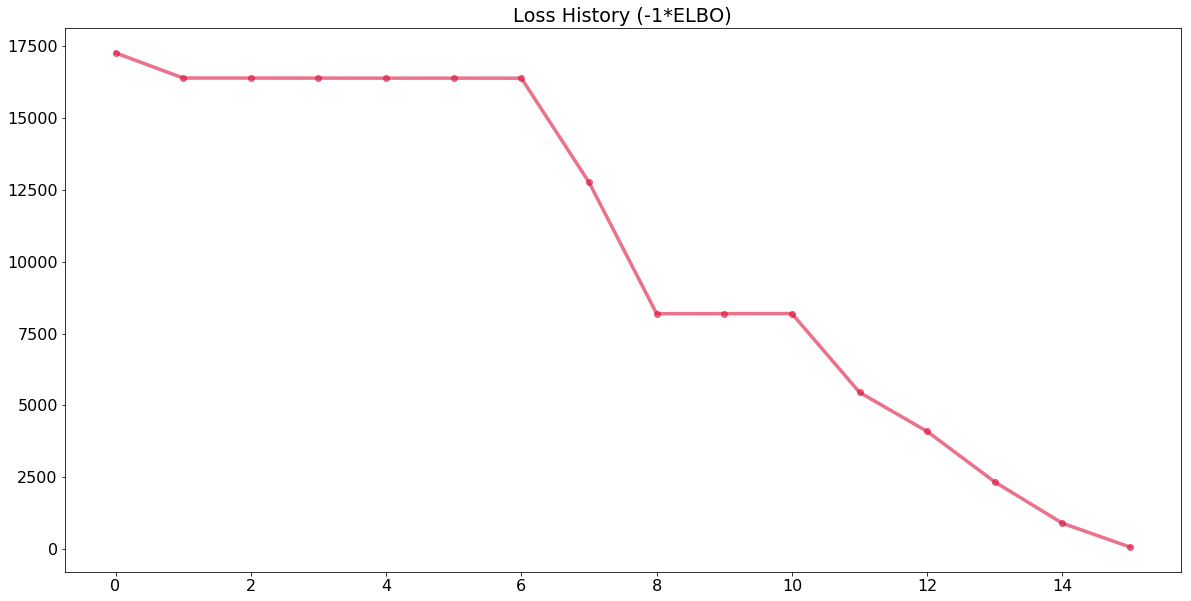

Epoch = 2 / 100
Data transfer to device completed.
Starting Encoding
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 1993.4789
CONV 1 OUT SUM = -6327.3594
RELU 1 OUT SUM = 2156.9473
MAX UNPOOL 1 OUT SUM = 2156.9475
CONV 2 OUT SUM = -45925.613
RELU 2 OUT SUM = 18825.459
MAX UNPOOL 2 OUT SUM = 18825.48
CONV 3 OUT SUM = -56631.9
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 0.36449516
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum


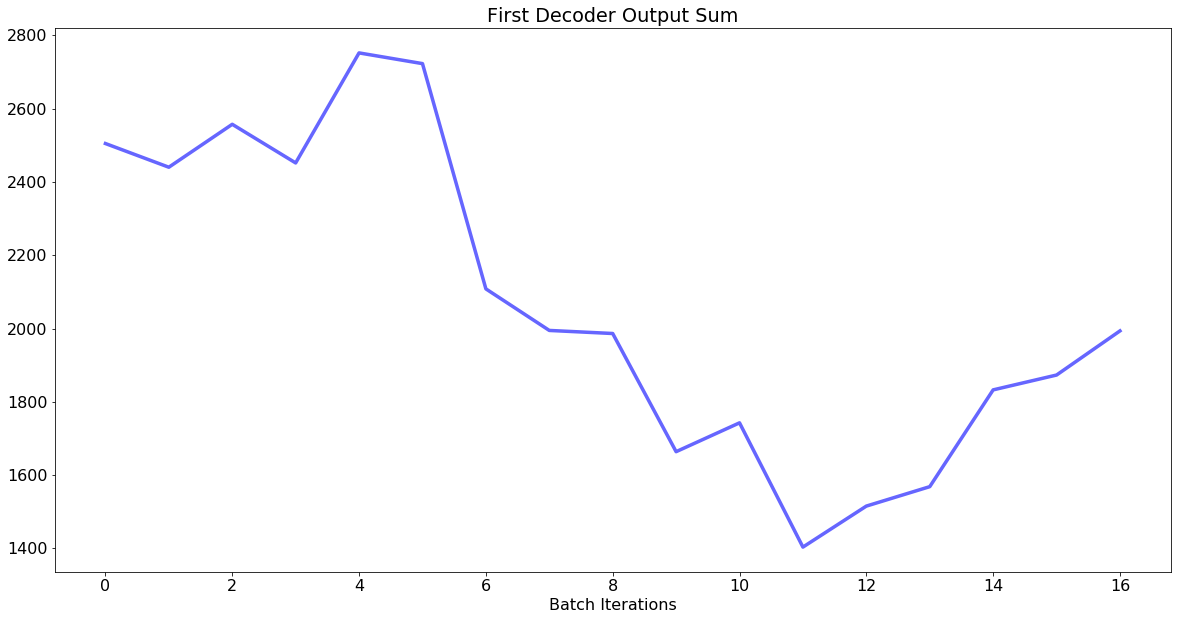

Plotting the first convolution output sum


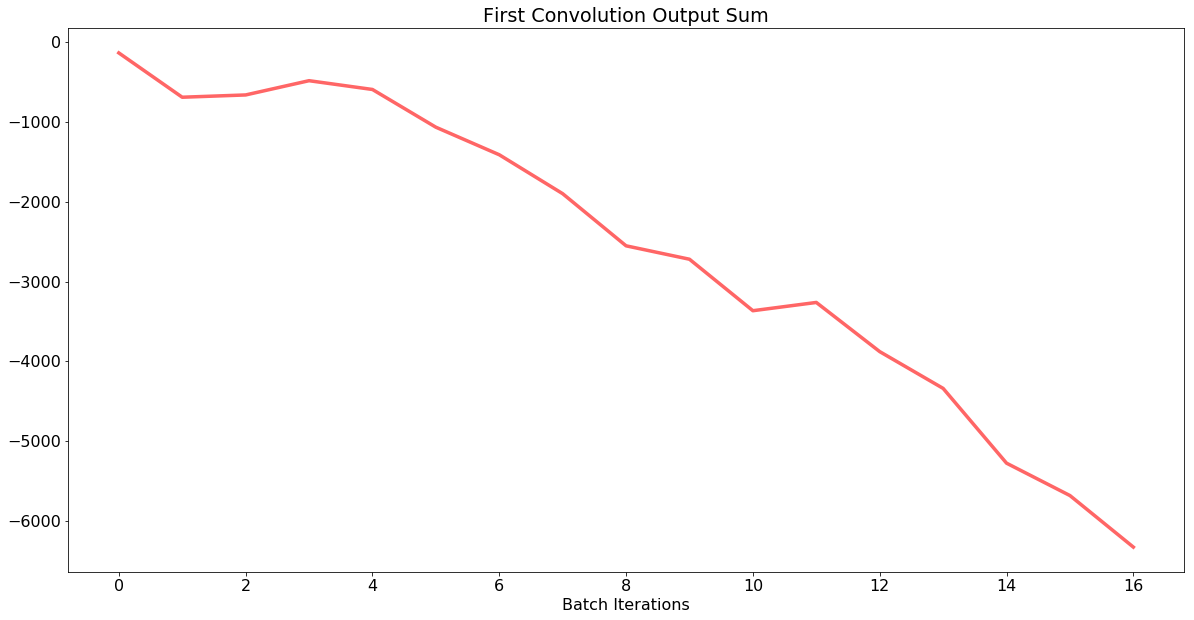

Plotting the first relu output sum


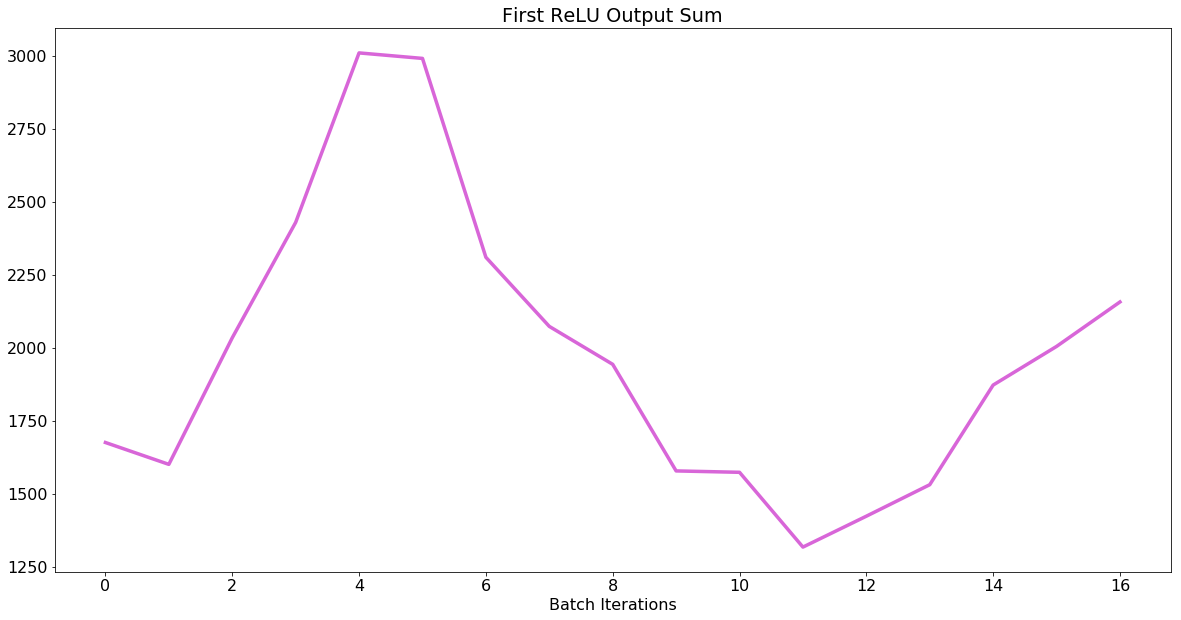

Plotting the first max unpool output sum


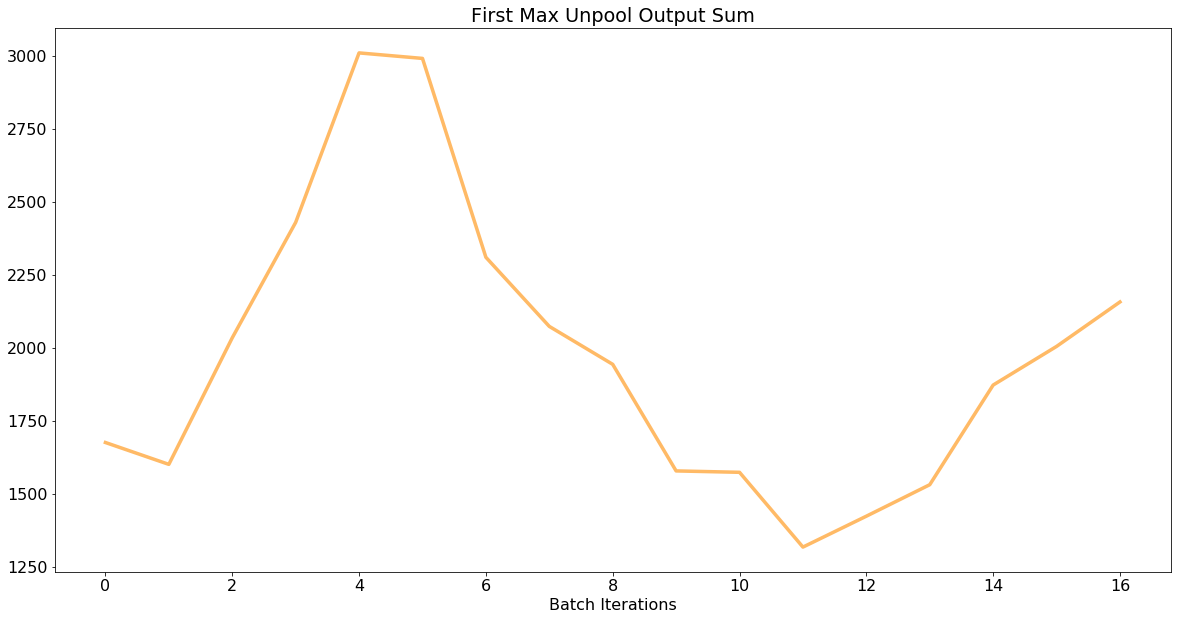

Plotting the second convolution output sum


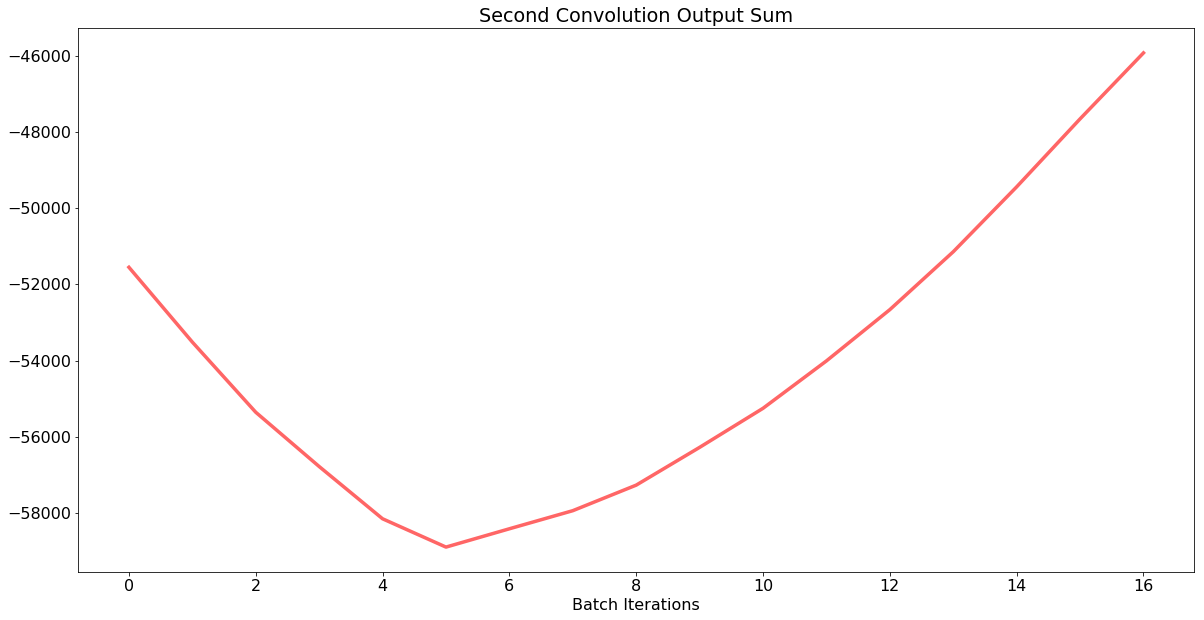

Plotting the second relu output sum


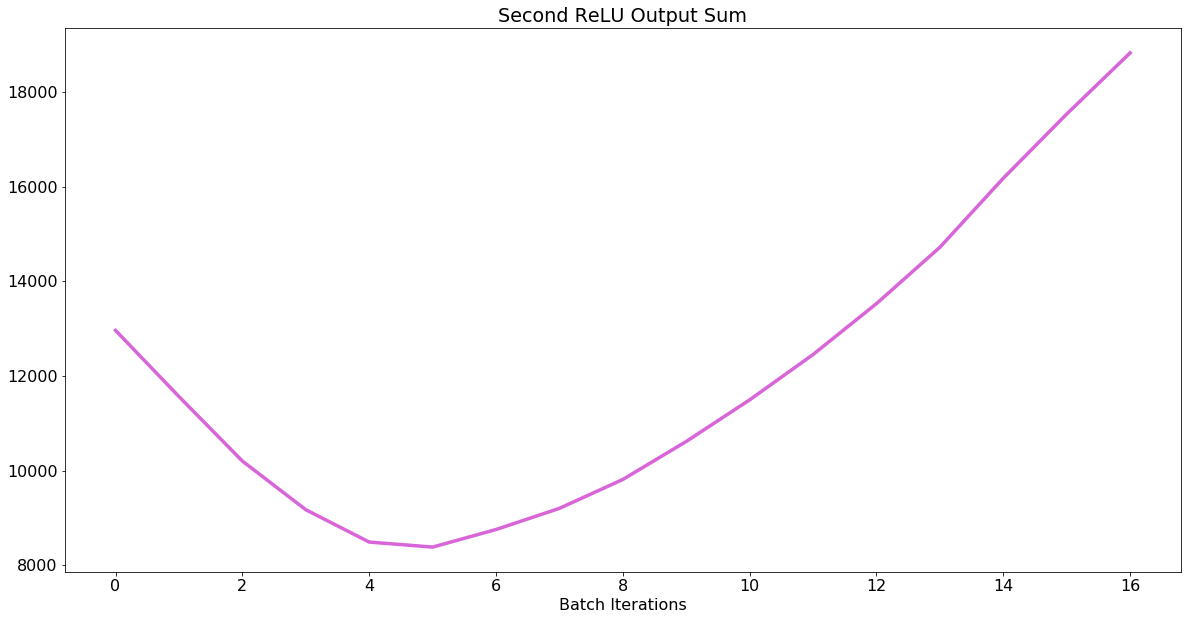

Plotting the second max unpool output sum


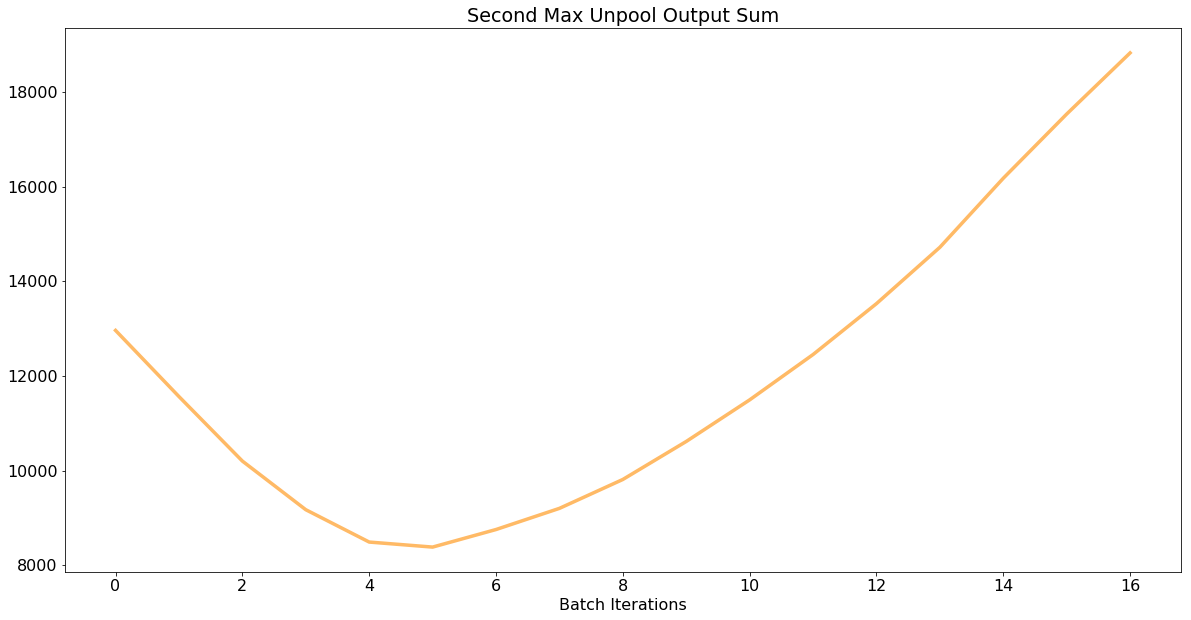

Plotting the third convolution output sum


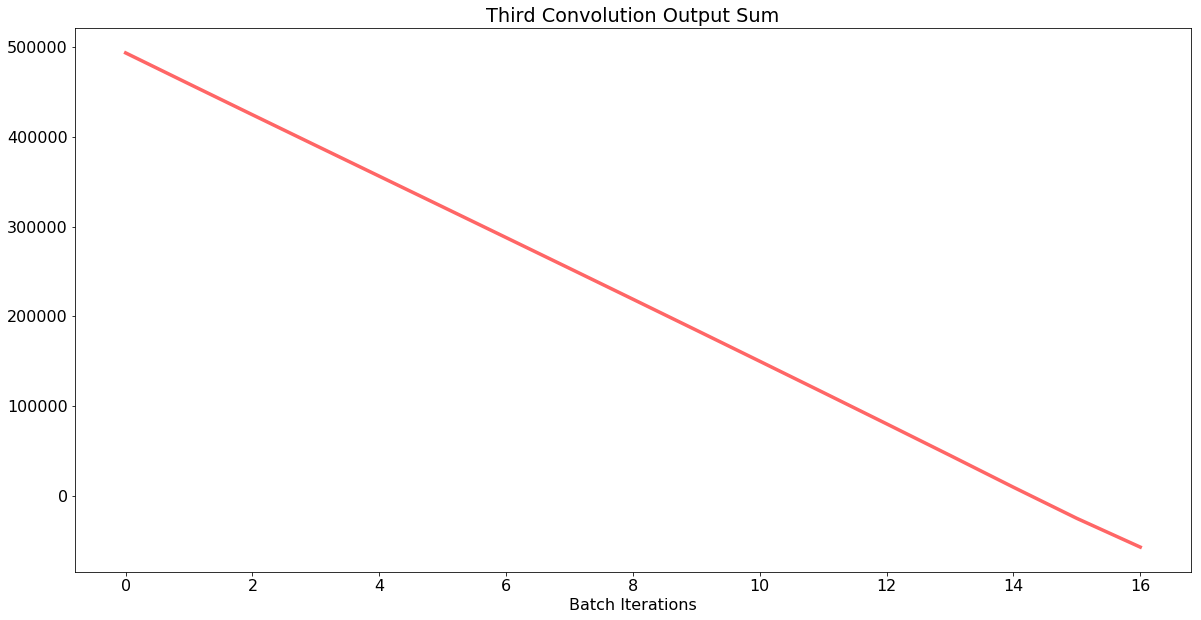

Plotting the third relu output sum


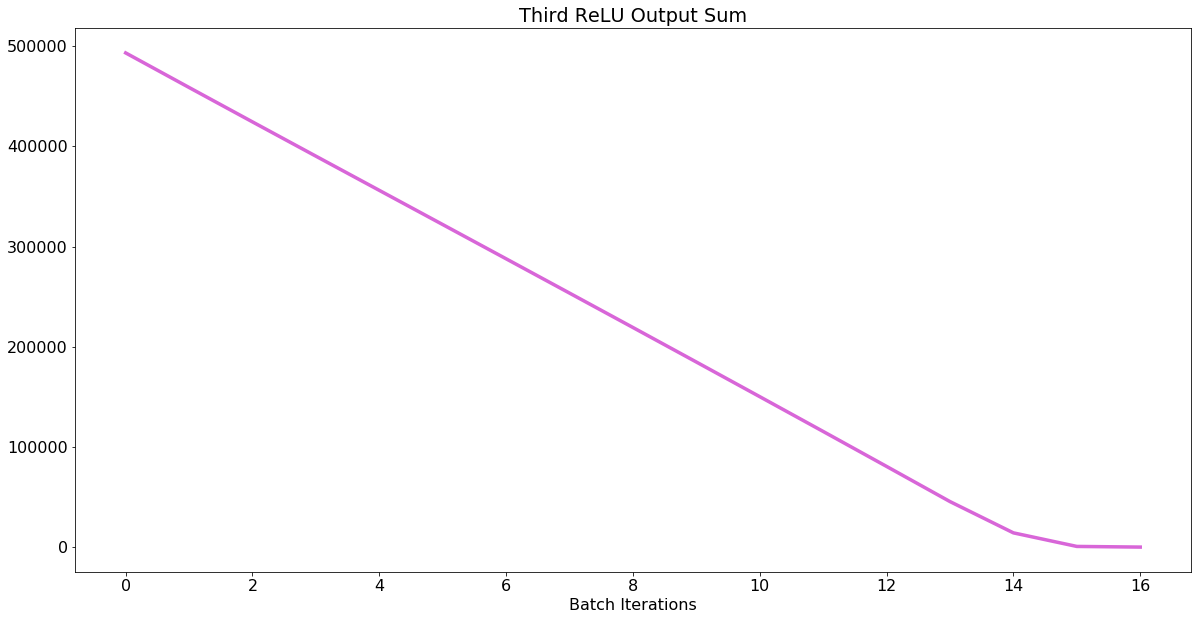

Visualizing original cube


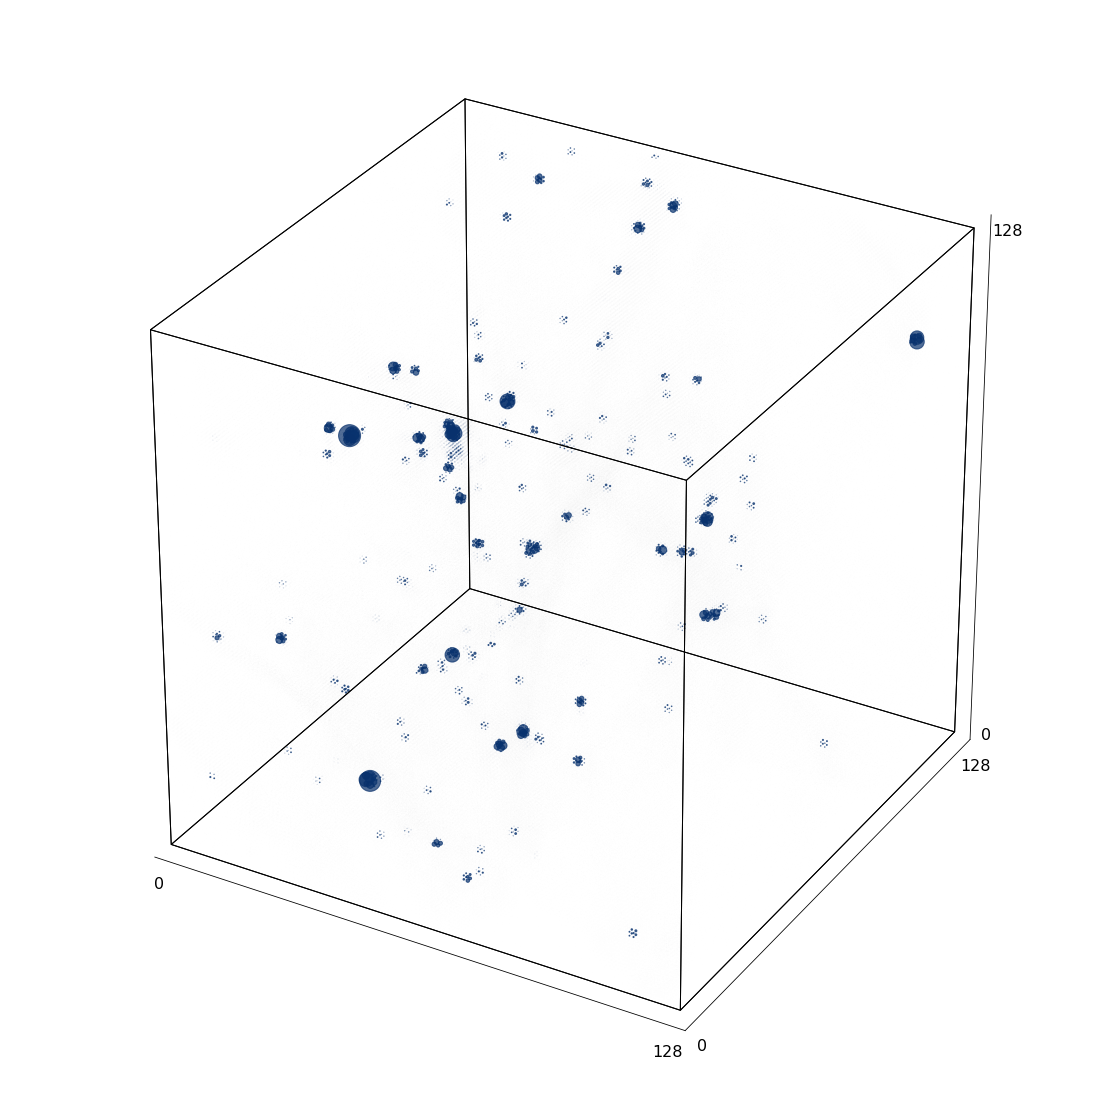

Visualizing reconstructed cube


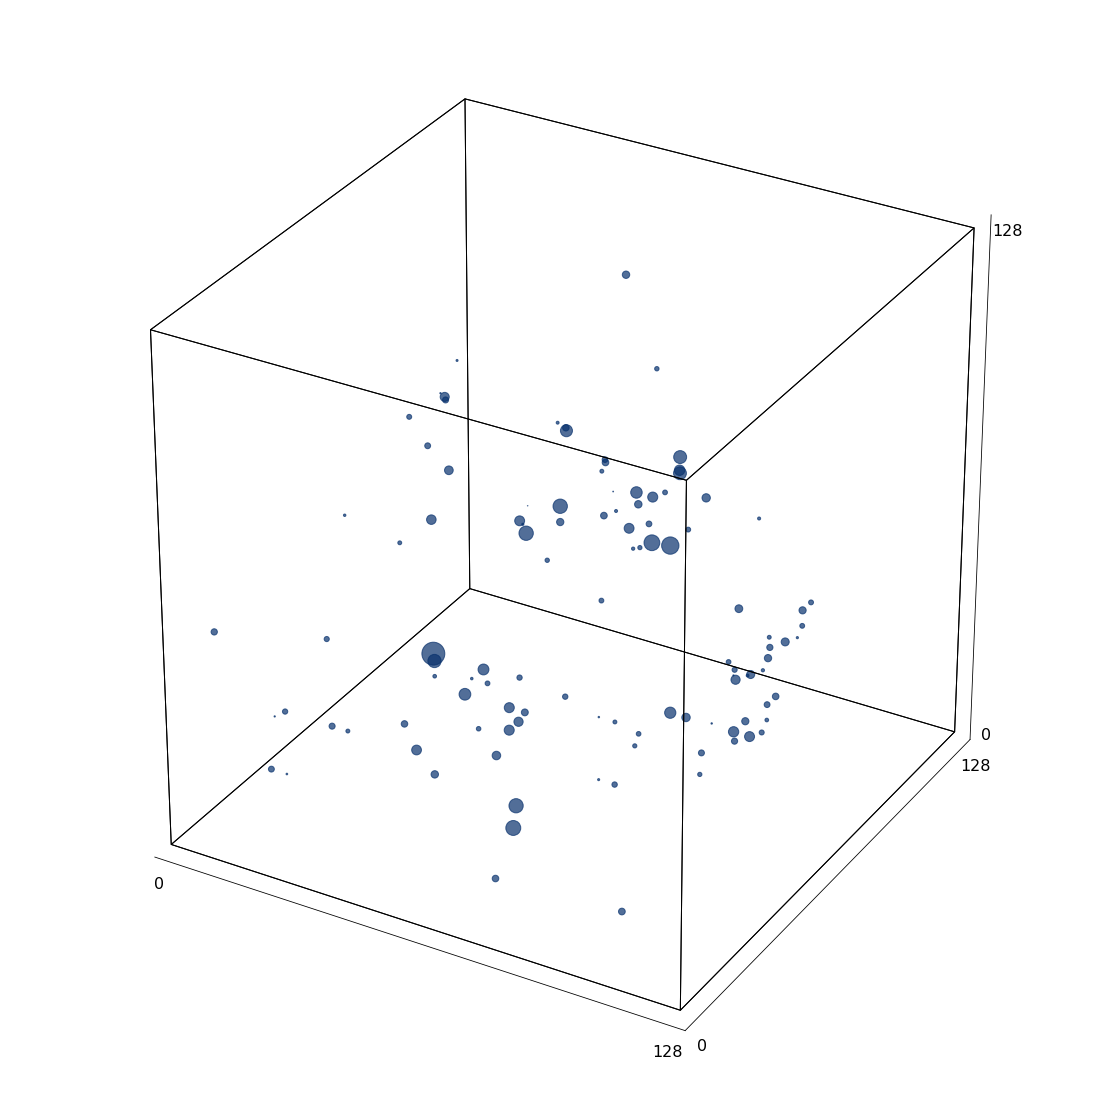

Output mass sum (reconstructed batch): 0.0075154444
--------------------------------------
Calculating Loss...
recon_x shape = torch.Size([16, 1, 128, 128, 128])
BCE Loss = tensor(640.3251, grad_fn=<BinaryCrossEntropyBackward>)
KLD =tensor(0.2725, grad_fn=<MulBackward>)
ELBO = tensor(-40.0373, grad_fn=<DivBackward0>)
Train Epoch: 2 [0/256 (0%)]	Loss: 2.502334356308
Data transfer to device completed.
Starting Encoding
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 1812.0293
CONV 1 OUT SUM = -6171.965
RELU 1 OUT SUM = 2043.9403
MAX UNPOOL 1 OUT SUM = 2043.9401
CONV 2 OUT SUM = -44495.645
RELU 2 OUT SUM = 19777.182
MAX UNPOOL 2 OUT SUM = 19777.18
CONV 3 OUT SUM = -85561.34
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 1.4526537e-05
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
--------------------------------------
Calculating Loss...
recon_x shape = torch.Size([16, 1, 128, 128, 128])
BCE Loss = tensor(419.3892,

BCE Loss = tensor(554.0609, grad_fn=<BinaryCrossEntropyBackward>)
KLD =tensor(0.2889, grad_fn=<MulBackward>)
ELBO = tensor(-34.6469, grad_fn=<DivBackward0>)
Train Epoch: 2 [160/256 (62%)]	Loss: 2.165429115295
Data transfer to device completed.
Starting Encoding
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 1948.9943
CONV 1 OUT SUM = -8475.109
RELU 1 OUT SUM = 2533.4219
MAX UNPOOL 1 OUT SUM = 2533.4224
CONV 2 OUT SUM = -34575.332
RELU 2 OUT SUM = 27663.352
MAX UNPOOL 2 OUT SUM = 27663.344
CONV 3 OUT SUM = -267924.0
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 0.0
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
--------------------------------------
Calculating Loss...
recon_x shape = torch.Size([16, 1, 128, 128, 128])
BCE Loss = tensor(835.8798, grad_fn=<BinaryCrossEntropyBackward>)
KLD =tensor(0.2127, grad_fn=<MulBackward>)
ELBO = tensor(-52.2558, grad_fn=<DivBackward0>)
Train Epoch: 2 [176/256 (69%)]	Loss: 3

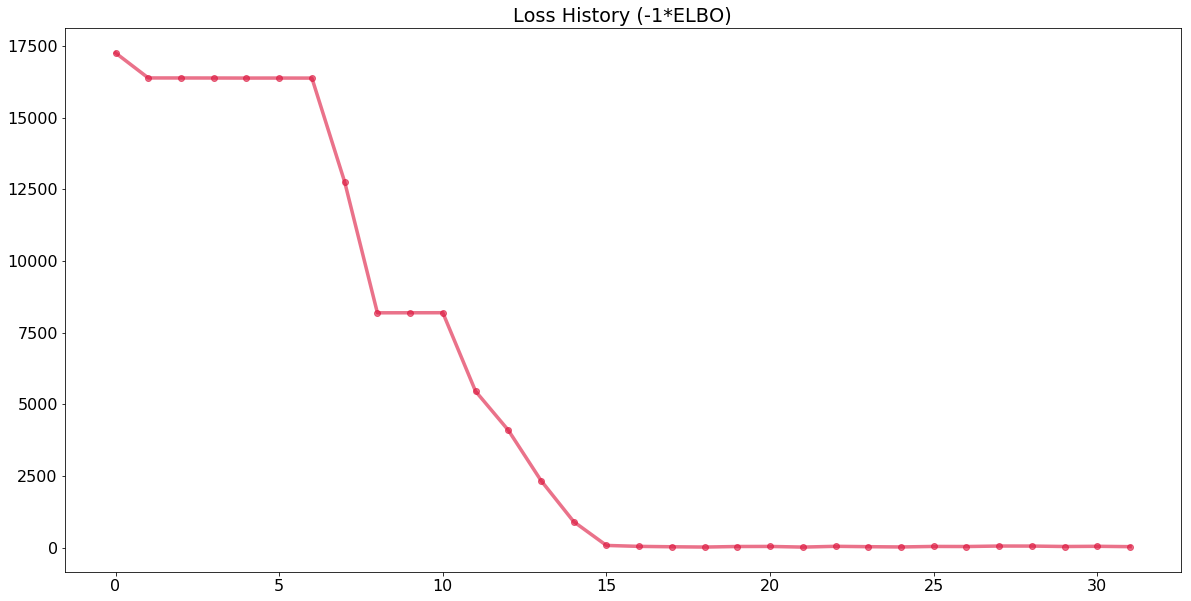

Epoch = 3 / 100
Data transfer to device completed.
Starting Encoding
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 2178.163
CONV 1 OUT SUM = -9937.197
RELU 1 OUT SUM = 2921.3337
MAX UNPOOL 1 OUT SUM = 2921.3333
CONV 2 OUT SUM = -31635.525
RELU 2 OUT SUM = 30200.62
MAX UNPOOL 2 OUT SUM = 30200.62
CONV 3 OUT SUM = -313409.03
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 0.0
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
--------------------------------------
Calculating Loss...
recon_x shape = torch.Size([16, 1, 128, 128, 128])
BCE Loss = tensor(206.6616, grad_fn=<BinaryCrossEntropyBackward>)
KLD =tensor(0.1993, grad_fn=<MulBackward>)
ELBO = tensor(-12.9288, grad_fn=<DivBackward0>)
Train Epoch: 3 [0/256 (0%)]	Loss: 0.808050274849
Data transfer to device completed.
Starting Encoding
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 2160.8433
CONV 1 OUT SUM = -9919.925
RELU 1 OUT SUM = 2910.

MAX UNPOOL 2 OUT SUM = 33000.016
CONV 3 OUT SUM = -360417.47
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 0.0
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
--------------------------------------
Calculating Loss...
recon_x shape = torch.Size([16, 1, 128, 128, 128])
BCE Loss = tensor(542.9772, grad_fn=<BinaryCrossEntropyBackward>)
KLD =tensor(0.1354, grad_fn=<MulBackward>)
ELBO = tensor(-33.9445, grad_fn=<DivBackward0>)
Train Epoch: 3 [160/256 (62%)]	Loss: 2.121533870697
Data transfer to device completed.
Starting Encoding
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 2144.4863
CONV 1 OUT SUM = -10319.12
RELU 1 OUT SUM = 3004.746
MAX UNPOOL 1 OUT SUM = 3004.745
CONV 2 OUT SUM = -28734.535
RELU 2 OUT SUM = 32426.14
MAX UNPOOL 2 OUT SUM = 32426.164
CONV 3 OUT SUM = -362184.7
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 0.0
data shape = torch.Size([16, 128, 128, 128])
data shape = (128

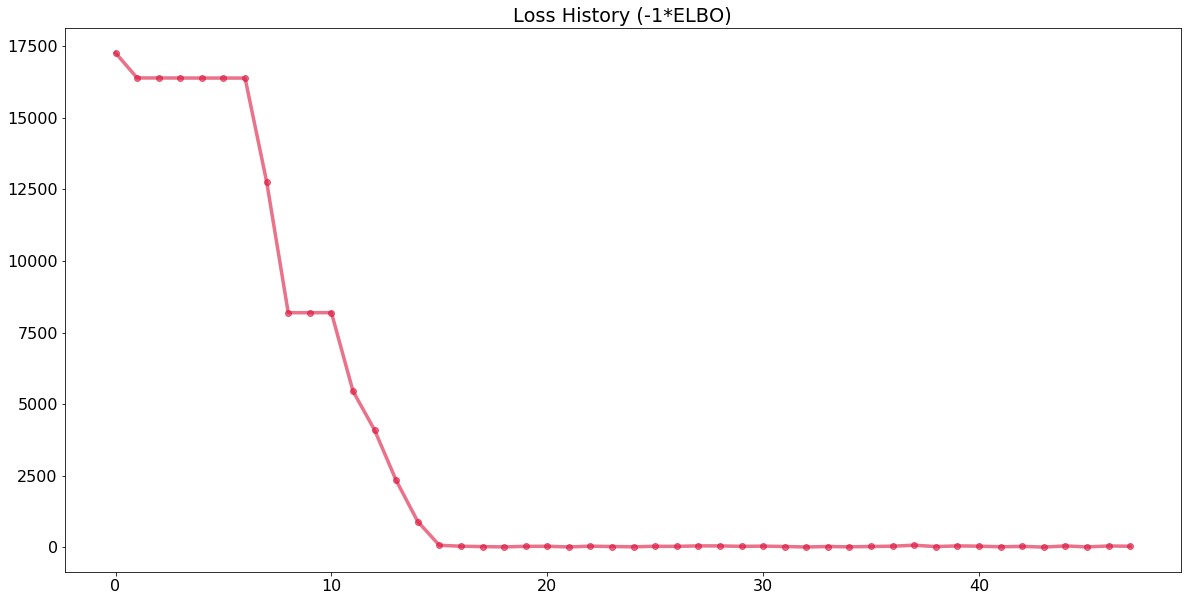

Epoch = 4 / 100
Data transfer to device completed.
Starting Encoding
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 2233.7485
CONV 1 OUT SUM = -10863.926
RELU 1 OUT SUM = 3135.1133
MAX UNPOOL 1 OUT SUM = 3135.1133
CONV 2 OUT SUM = -27869.572
RELU 2 OUT SUM = 33098.15
MAX UNPOOL 2 OUT SUM = 33098.13
CONV 3 OUT SUM = -372571.88
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 0.0
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum


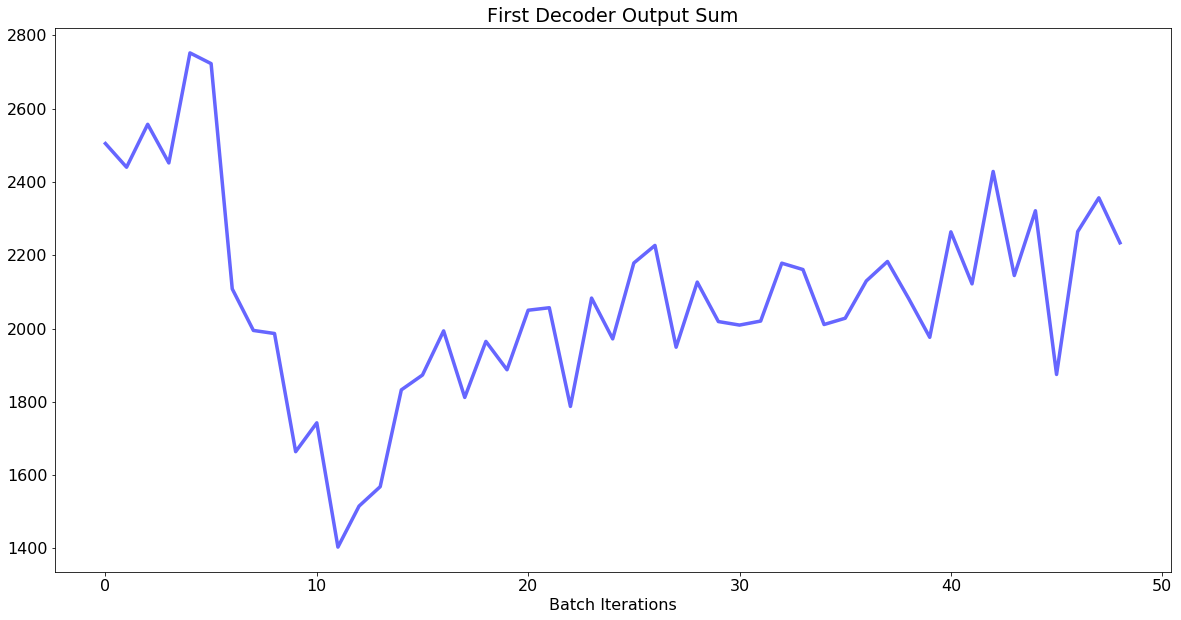

Plotting the first convolution output sum


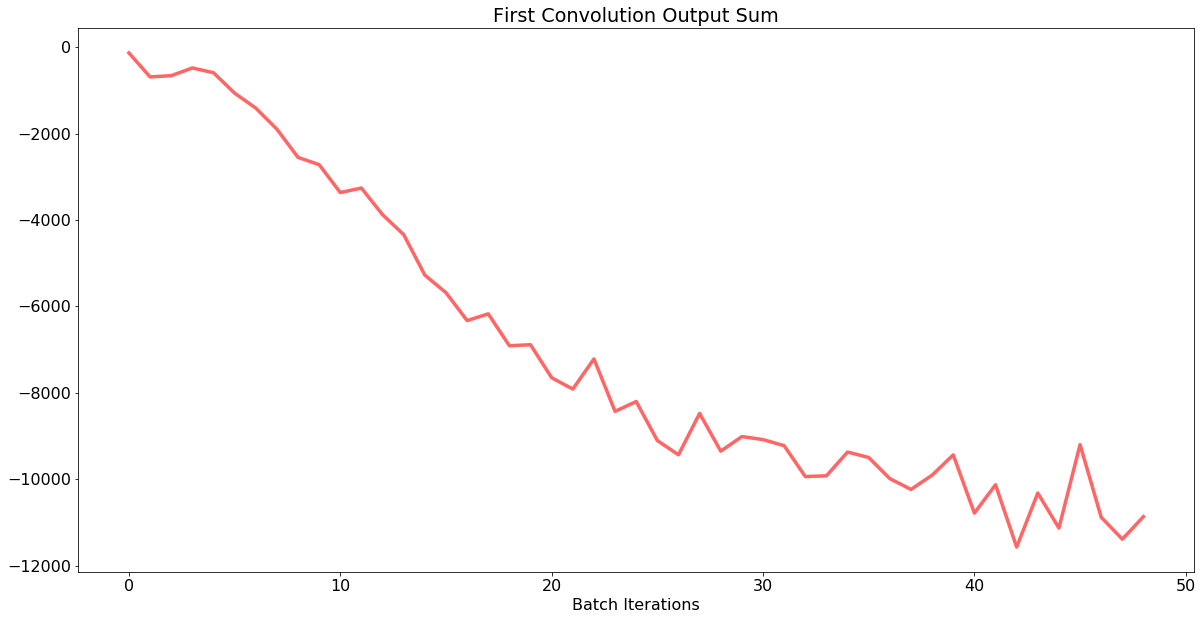

Plotting the first relu output sum


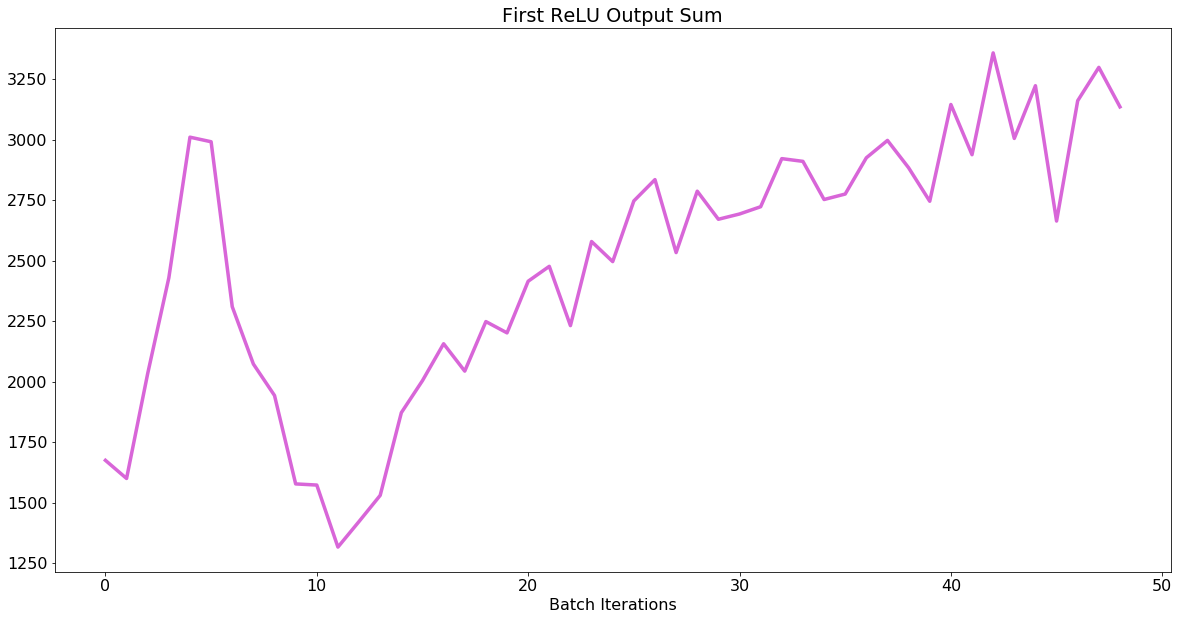

Plotting the first max unpool output sum


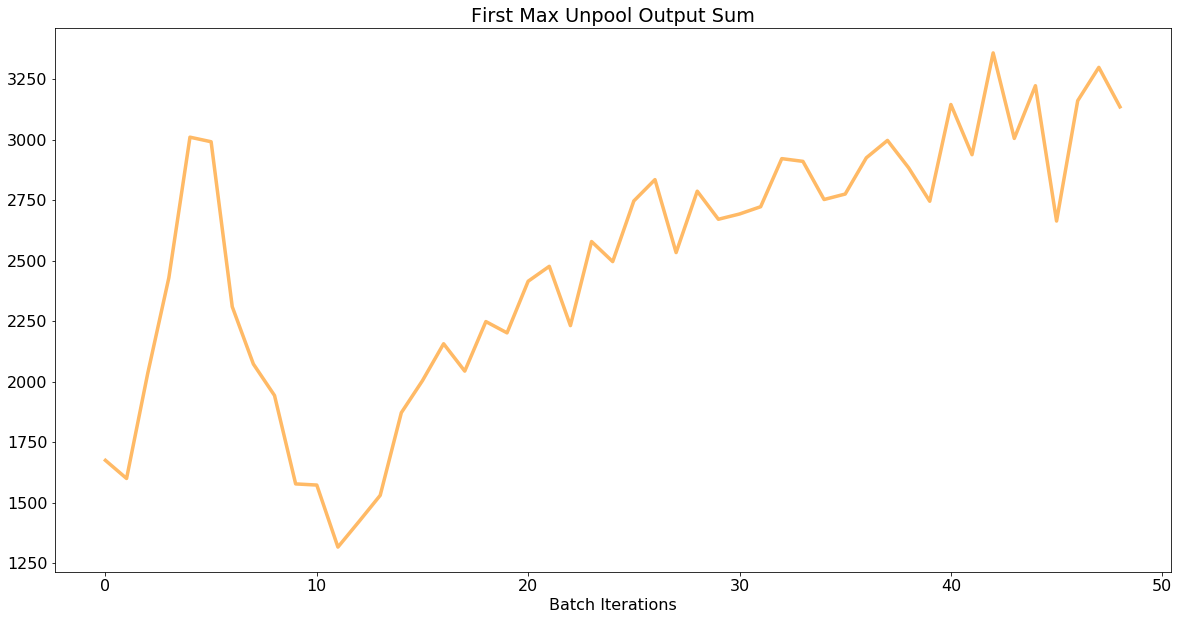

Plotting the second convolution output sum


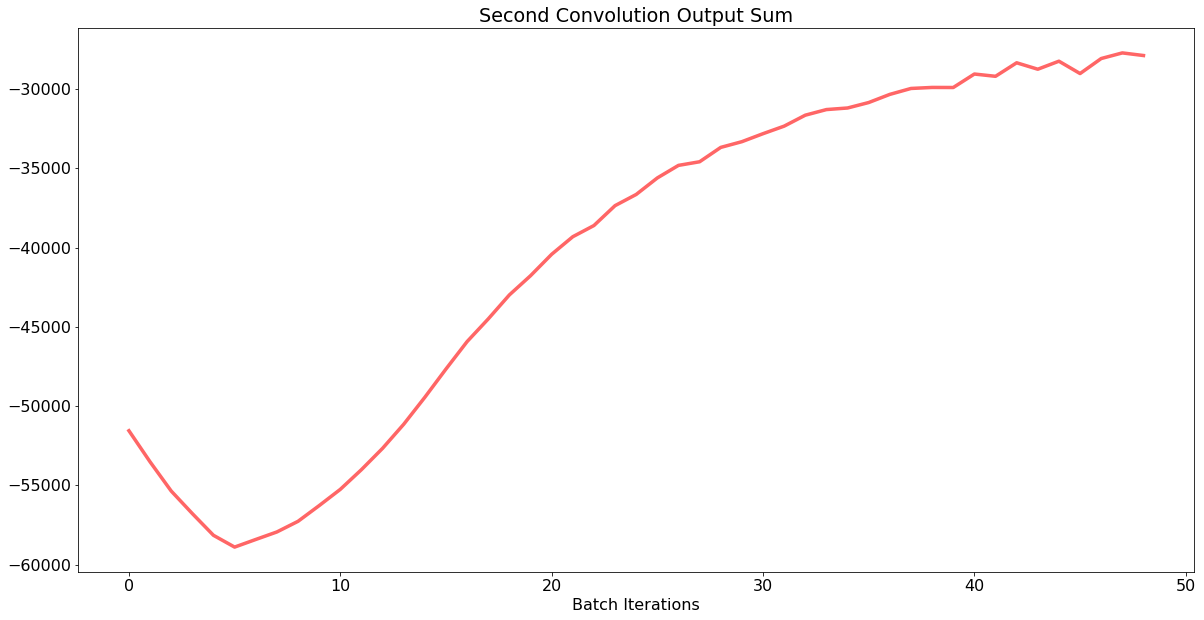

Plotting the second relu output sum


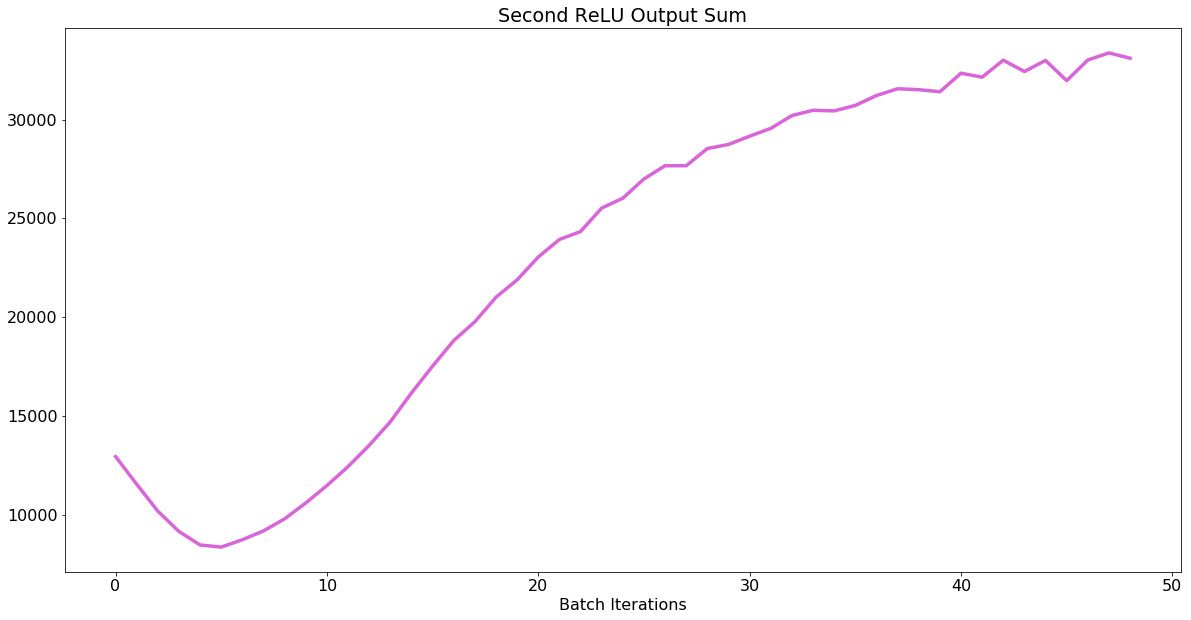

Plotting the second max unpool output sum


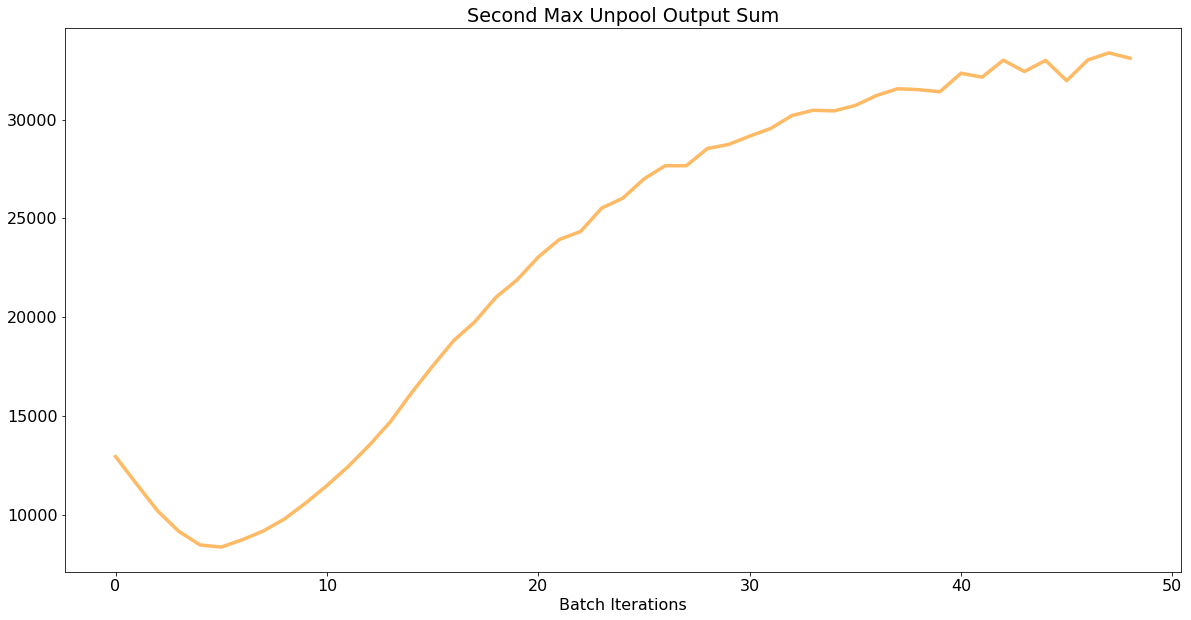

Plotting the third convolution output sum


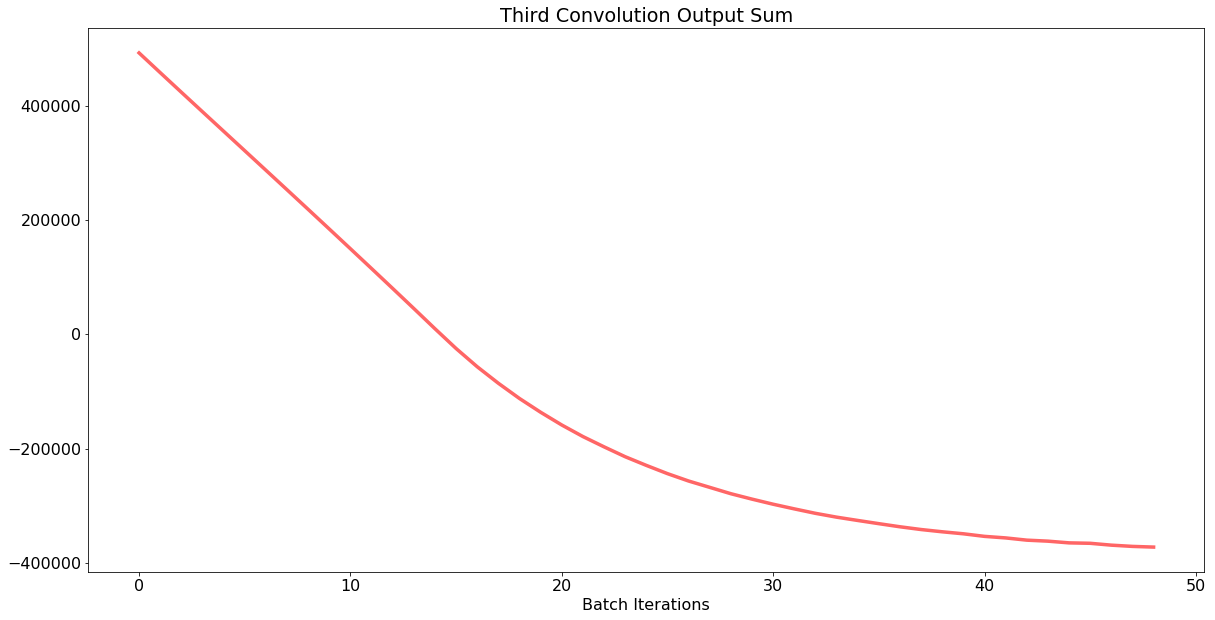

Plotting the third relu output sum


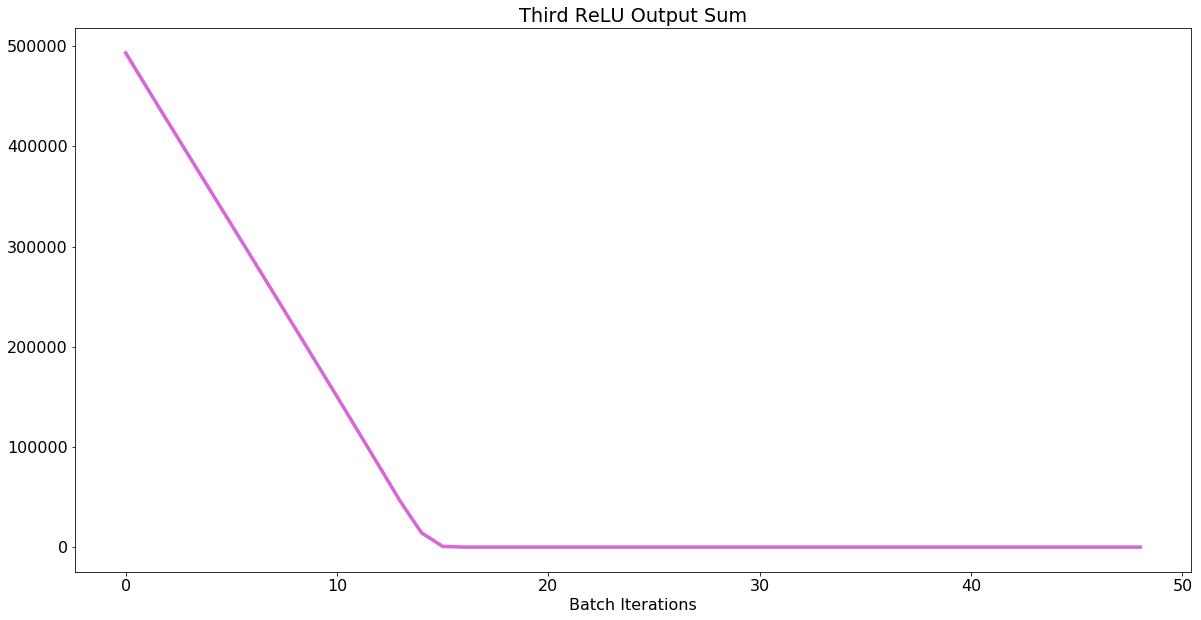

Visualizing original cube


KeyboardInterrupt: 

In [91]:
if __name__ == "__main__":
    
    loss_history = []
    
    decoder_sum_lists = {}
        
    for out_plot in ["first_decode_out_sum", "conv_1_out_sum", "relu_1_out_sum", "max_unpool_1_out_sum",
                    "conv_2_out_sum", "relu_2_out_sum", "max_unpool_2_out_sum", "conv_3_out_sum", \
                    "relu_3_out_sum"]:
            
        decoder_sum_lists[out_plot] = []
            
    for epoch in range(1, epochs + 1):
        print("Epoch = " + str(epoch) + " / " + str(epochs))
        
        train(epoch)
        
        # Plotting Training Losses
        plt.figure(figsize=(20,10))
#         plt.ylim(-0.0001,0.7)
        plt.plot(loss_history, linewidth=3.5, alpha=0.6,
                color="crimson", marker="o")
        plt.rcParams["font.size"] = 16
        plt.title("Loss History (-1*ELBO)")
        plt.show()
        

#         test(epoch)
        
        
#         with torch.no_grad():
#             sample = torch.randn(64, 20).to(device)
#             sample = model.decode(sample).cpu()
#             save_image(sample.view(64, 1, 28, 28),
#                        'results/sample_' + str(epoch) + '.png')